# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

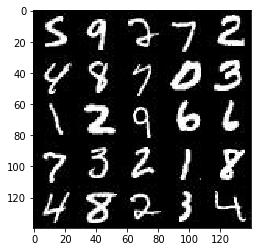

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

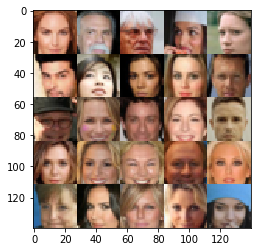

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_height,image_width,image_channels),name="input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name="input_z")
    learning_rate_pl =tf.placeholder(tf.float32,name="learning_rate")
    return input_real,input_z,learning_rate_pl


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.20
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z,out_channel_dim,is_train=True)
    
    d_model_real,d_logits_real =discriminator(input_real,reuse=False)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(
                  logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(
             logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
                  learning_rate, beta1=beta1).minimize(
                  d_loss, var_list=d_vars)
    with tf.control_dependencies(
         tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(
                      learning_rate, beta1=beta1).minimize(
                      g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0/2... Discriminator Loss: 3.6283... Generator Loss: 0.0527
Epoch 0/2... Discriminator Loss: 1.7801... Generator Loss: 1.4458
Epoch 0/2... Discriminator Loss: 0.9752... Generator Loss: 1.0270
Epoch 0/2... Discriminator Loss: 0.5989... Generator Loss: 2.3650


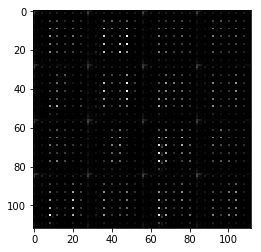

Epoch 0/2... Discriminator Loss: 0.9955... Generator Loss: 1.2320
Epoch 0/2... Discriminator Loss: 2.5341... Generator Loss: 0.1768
Epoch 0/2... Discriminator Loss: 1.1950... Generator Loss: 1.0549
Epoch 0/2... Discriminator Loss: 1.6289... Generator Loss: 0.8004
Epoch 0/2... Discriminator Loss: 1.4998... Generator Loss: 0.8922


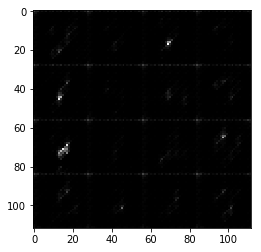

Epoch 0/2... Discriminator Loss: 1.5069... Generator Loss: 0.6615
Epoch 0/2... Discriminator Loss: 1.0831... Generator Loss: 1.1914
Epoch 0/2... Discriminator Loss: 1.2318... Generator Loss: 0.7786
Epoch 0/2... Discriminator Loss: 1.7186... Generator Loss: 2.1388
Epoch 0/2... Discriminator Loss: 1.6265... Generator Loss: 0.6090


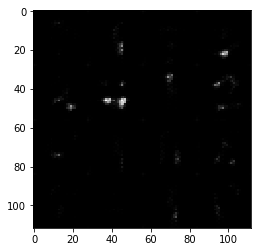

Epoch 0/2... Discriminator Loss: 1.6441... Generator Loss: 0.6332
Epoch 0/2... Discriminator Loss: 1.3810... Generator Loss: 0.7477
Epoch 0/2... Discriminator Loss: 1.2041... Generator Loss: 0.8705
Epoch 0/2... Discriminator Loss: 1.7271... Generator Loss: 0.3587
Epoch 0/2... Discriminator Loss: 1.6444... Generator Loss: 1.6352


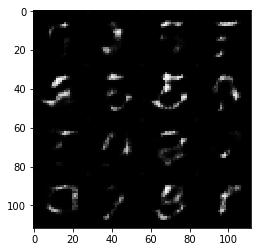

Epoch 0/2... Discriminator Loss: 1.5367... Generator Loss: 1.7365
Epoch 0/2... Discriminator Loss: 1.3630... Generator Loss: 1.3248
Epoch 0/2... Discriminator Loss: 1.5158... Generator Loss: 0.7844
Epoch 0/2... Discriminator Loss: 1.5818... Generator Loss: 0.6078
Epoch 0/2... Discriminator Loss: 1.3409... Generator Loss: 1.1954


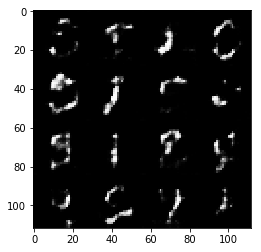

Epoch 0/2... Discriminator Loss: 1.8939... Generator Loss: 0.3466
Epoch 0/2... Discriminator Loss: 1.7052... Generator Loss: 1.2412
Epoch 0/2... Discriminator Loss: 1.6787... Generator Loss: 1.4687
Epoch 0/2... Discriminator Loss: 1.4282... Generator Loss: 0.6651
Epoch 0/2... Discriminator Loss: 1.4818... Generator Loss: 0.5376


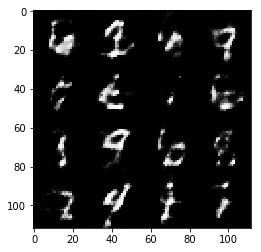

Epoch 0/2... Discriminator Loss: 1.3971... Generator Loss: 1.2499
Epoch 0/2... Discriminator Loss: 1.3900... Generator Loss: 0.5748
Epoch 0/2... Discriminator Loss: 1.3522... Generator Loss: 0.6398
Epoch 0/2... Discriminator Loss: 1.3217... Generator Loss: 0.8198
Epoch 0/2... Discriminator Loss: 1.3668... Generator Loss: 1.2664


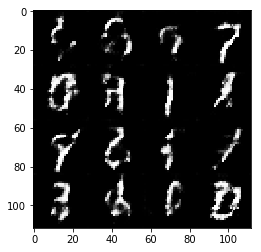

Epoch 0/2... Discriminator Loss: 1.3307... Generator Loss: 1.0710
Epoch 0/2... Discriminator Loss: 1.2202... Generator Loss: 0.7873
Epoch 0/2... Discriminator Loss: 1.6476... Generator Loss: 0.4009
Epoch 0/2... Discriminator Loss: 1.7625... Generator Loss: 0.3334
Epoch 0/2... Discriminator Loss: 1.2197... Generator Loss: 1.1903


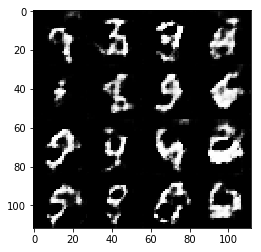

Epoch 0/2... Discriminator Loss: 1.3067... Generator Loss: 0.6784
Epoch 0/2... Discriminator Loss: 1.5965... Generator Loss: 0.4251
Epoch 0/2... Discriminator Loss: 1.2652... Generator Loss: 0.8966
Epoch 0/2... Discriminator Loss: 1.3896... Generator Loss: 0.5567
Epoch 0/2... Discriminator Loss: 1.2160... Generator Loss: 1.0167


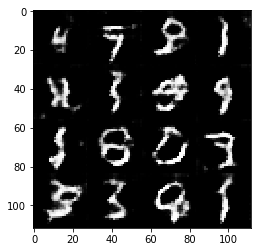

Epoch 0/2... Discriminator Loss: 1.3624... Generator Loss: 0.9546
Epoch 0/2... Discriminator Loss: 1.1810... Generator Loss: 0.9082
Epoch 0/2... Discriminator Loss: 1.2168... Generator Loss: 1.2183
Epoch 0/2... Discriminator Loss: 1.2762... Generator Loss: 0.8288
Epoch 0/2... Discriminator Loss: 1.1768... Generator Loss: 1.2127


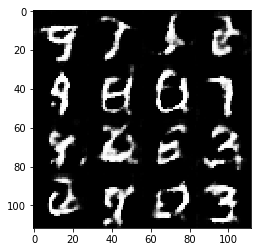

Epoch 0/2... Discriminator Loss: 1.3085... Generator Loss: 1.2378
Epoch 0/2... Discriminator Loss: 1.2133... Generator Loss: 0.7448
Epoch 0/2... Discriminator Loss: 1.2728... Generator Loss: 0.8064
Epoch 0/2... Discriminator Loss: 1.3018... Generator Loss: 0.9400
Epoch 0/2... Discriminator Loss: 1.1599... Generator Loss: 1.5728


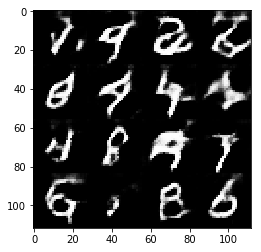

Epoch 0/2... Discriminator Loss: 1.3358... Generator Loss: 0.5430
Epoch 0/2... Discriminator Loss: 1.1828... Generator Loss: 0.9891
Epoch 0/2... Discriminator Loss: 1.3390... Generator Loss: 0.7006
Epoch 0/2... Discriminator Loss: 1.5510... Generator Loss: 0.4448
Epoch 0/2... Discriminator Loss: 1.3051... Generator Loss: 0.9830


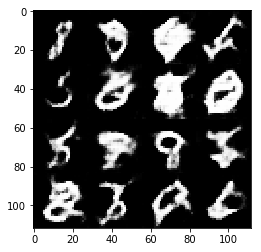

Epoch 0/2... Discriminator Loss: 1.3106... Generator Loss: 0.7694
Epoch 0/2... Discriminator Loss: 1.2570... Generator Loss: 0.6632
Epoch 0/2... Discriminator Loss: 1.2628... Generator Loss: 1.5417
Epoch 0/2... Discriminator Loss: 1.3533... Generator Loss: 0.8933
Epoch 0/2... Discriminator Loss: 1.3800... Generator Loss: 0.5954


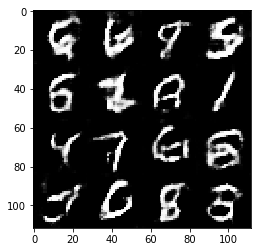

Epoch 0/2... Discriminator Loss: 1.3110... Generator Loss: 0.7176
Epoch 0/2... Discriminator Loss: 1.5013... Generator Loss: 0.4453
Epoch 0/2... Discriminator Loss: 1.3971... Generator Loss: 1.8007
Epoch 0/2... Discriminator Loss: 1.4140... Generator Loss: 0.9175
Epoch 0/2... Discriminator Loss: 1.4645... Generator Loss: 0.6610


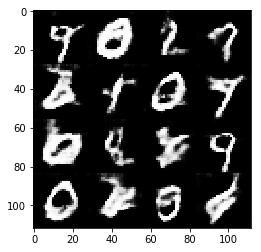

Epoch 0/2... Discriminator Loss: 1.2713... Generator Loss: 0.9058
Epoch 0/2... Discriminator Loss: 1.1656... Generator Loss: 1.1836
Epoch 0/2... Discriminator Loss: 1.2438... Generator Loss: 1.4630
Epoch 0/2... Discriminator Loss: 1.4377... Generator Loss: 0.6598
Epoch 0/2... Discriminator Loss: 1.1941... Generator Loss: 0.9833


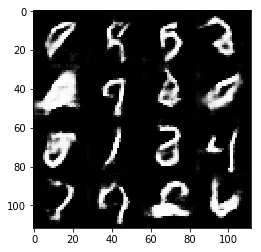

Epoch 0/2... Discriminator Loss: 1.4230... Generator Loss: 0.5418
Epoch 0/2... Discriminator Loss: 1.5727... Generator Loss: 0.4700
Epoch 0/2... Discriminator Loss: 1.3696... Generator Loss: 0.5819
Epoch 0/2... Discriminator Loss: 1.3284... Generator Loss: 1.8167
Epoch 0/2... Discriminator Loss: 1.1360... Generator Loss: 0.9631


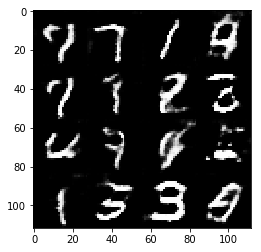

Epoch 0/2... Discriminator Loss: 1.2784... Generator Loss: 0.8527
Epoch 0/2... Discriminator Loss: 1.1865... Generator Loss: 0.7298
Epoch 0/2... Discriminator Loss: 1.2508... Generator Loss: 0.9641
Epoch 0/2... Discriminator Loss: 1.2913... Generator Loss: 0.9328
Epoch 0/2... Discriminator Loss: 1.6127... Generator Loss: 0.4268


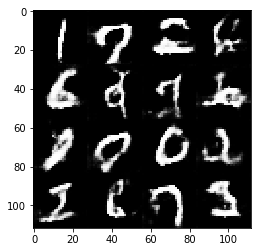

Epoch 0/2... Discriminator Loss: 1.6180... Generator Loss: 0.3895
Epoch 0/2... Discriminator Loss: 1.1898... Generator Loss: 0.8075
Epoch 0/2... Discriminator Loss: 1.3001... Generator Loss: 0.5857
Epoch 0/2... Discriminator Loss: 1.2107... Generator Loss: 1.3058
Epoch 0/2... Discriminator Loss: 1.2485... Generator Loss: 0.9418


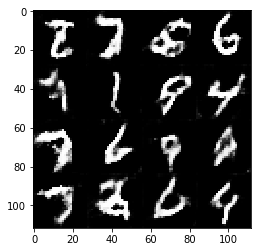

Epoch 0/2... Discriminator Loss: 1.3883... Generator Loss: 0.5808
Epoch 0/2... Discriminator Loss: 1.2852... Generator Loss: 0.7770
Epoch 0/2... Discriminator Loss: 1.3025... Generator Loss: 0.6004
Epoch 0/2... Discriminator Loss: 1.2290... Generator Loss: 0.9683
Epoch 0/2... Discriminator Loss: 1.1869... Generator Loss: 1.1060


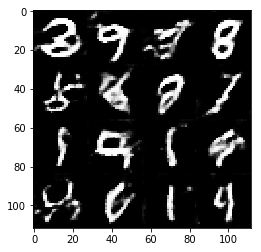

Epoch 0/2... Discriminator Loss: 1.3132... Generator Loss: 1.0958
Epoch 0/2... Discriminator Loss: 1.1335... Generator Loss: 0.7965
Epoch 0/2... Discriminator Loss: 1.3673... Generator Loss: 0.7704
Epoch 0/2... Discriminator Loss: 1.2666... Generator Loss: 1.5525
Epoch 0/2... Discriminator Loss: 1.5008... Generator Loss: 0.4410


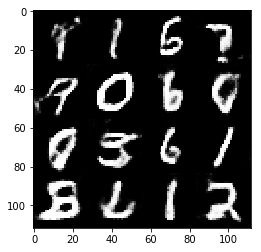

Epoch 0/2... Discriminator Loss: 1.2829... Generator Loss: 1.4357
Epoch 0/2... Discriminator Loss: 1.1461... Generator Loss: 1.1364
Epoch 0/2... Discriminator Loss: 1.3415... Generator Loss: 0.7910
Epoch 0/2... Discriminator Loss: 1.2144... Generator Loss: 1.4280
Epoch 0/2... Discriminator Loss: 1.3177... Generator Loss: 0.5972


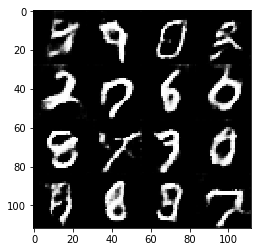

Epoch 0/2... Discriminator Loss: 1.3564... Generator Loss: 0.6361
Epoch 0/2... Discriminator Loss: 1.4001... Generator Loss: 1.6182
Epoch 0/2... Discriminator Loss: 1.1199... Generator Loss: 0.8747
Epoch 0/2... Discriminator Loss: 1.2279... Generator Loss: 0.8131
Epoch 0/2... Discriminator Loss: 1.5995... Generator Loss: 0.4453


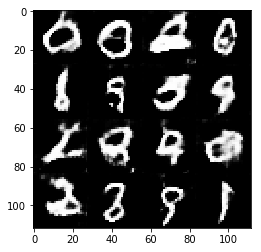

Epoch 0/2... Discriminator Loss: 1.4355... Generator Loss: 1.0563
Epoch 0/2... Discriminator Loss: 1.1675... Generator Loss: 0.8889
Epoch 0/2... Discriminator Loss: 1.2044... Generator Loss: 1.0904
Epoch 0/2... Discriminator Loss: 1.2154... Generator Loss: 0.7023
Epoch 0/2... Discriminator Loss: 1.2165... Generator Loss: 1.2694


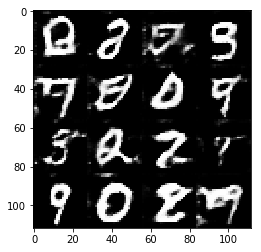

Epoch 0/2... Discriminator Loss: 1.7772... Generator Loss: 0.3475
Epoch 0/2... Discriminator Loss: 1.2597... Generator Loss: 0.8709
Epoch 0/2... Discriminator Loss: 1.1568... Generator Loss: 0.8392
Epoch 0/2... Discriminator Loss: 1.1673... Generator Loss: 1.2941
Epoch 0/2... Discriminator Loss: 1.2328... Generator Loss: 0.6748


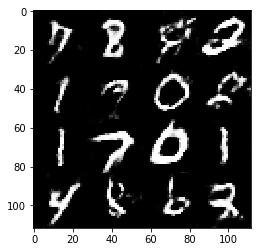

Epoch 0/2... Discriminator Loss: 1.3015... Generator Loss: 0.8709
Epoch 0/2... Discriminator Loss: 1.0142... Generator Loss: 1.3082
Epoch 0/2... Discriminator Loss: 1.9549... Generator Loss: 0.2483
Epoch 0/2... Discriminator Loss: 1.4371... Generator Loss: 0.4920
Epoch 0/2... Discriminator Loss: 1.2892... Generator Loss: 1.4863


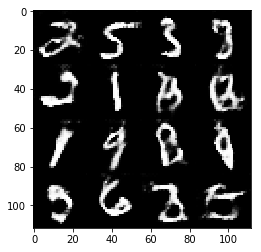

Epoch 0/2... Discriminator Loss: 1.5187... Generator Loss: 0.4357
Epoch 0/2... Discriminator Loss: 1.4210... Generator Loss: 0.4692
Epoch 0/2... Discriminator Loss: 1.5184... Generator Loss: 0.4568
Epoch 0/2... Discriminator Loss: 1.0312... Generator Loss: 1.2694
Epoch 0/2... Discriminator Loss: 1.0656... Generator Loss: 1.1898


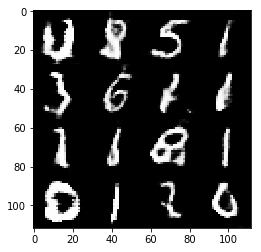

Epoch 0/2... Discriminator Loss: 1.6558... Generator Loss: 0.3891
Epoch 0/2... Discriminator Loss: 1.5750... Generator Loss: 0.4593
Epoch 0/2... Discriminator Loss: 1.3865... Generator Loss: 1.2546
Epoch 0/2... Discriminator Loss: 1.2949... Generator Loss: 0.6990
Epoch 0/2... Discriminator Loss: 1.2399... Generator Loss: 1.1529


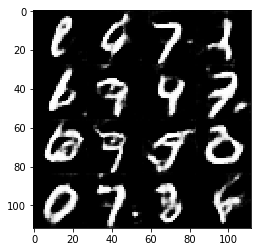

Epoch 0/2... Discriminator Loss: 1.2003... Generator Loss: 0.9569
Epoch 0/2... Discriminator Loss: 1.3129... Generator Loss: 0.6823
Epoch 0/2... Discriminator Loss: 1.1743... Generator Loss: 0.8016
Epoch 0/2... Discriminator Loss: 1.2584... Generator Loss: 0.7818
Epoch 0/2... Discriminator Loss: 1.3444... Generator Loss: 1.3551


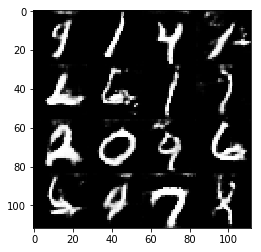

Epoch 0/2... Discriminator Loss: 1.2016... Generator Loss: 0.7518
Epoch 0/2... Discriminator Loss: 1.1985... Generator Loss: 0.9493
Epoch 0/2... Discriminator Loss: 1.3556... Generator Loss: 0.5693
Epoch 0/2... Discriminator Loss: 1.3711... Generator Loss: 0.6566
Epoch 0/2... Discriminator Loss: 1.0652... Generator Loss: 1.2932


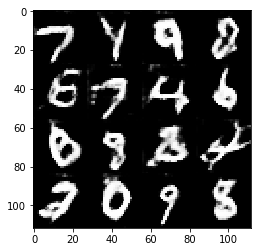

Epoch 0/2... Discriminator Loss: 1.1206... Generator Loss: 1.0618
Epoch 0/2... Discriminator Loss: 1.4807... Generator Loss: 0.4632
Epoch 0/2... Discriminator Loss: 1.6483... Generator Loss: 0.3954
Epoch 0/2... Discriminator Loss: 2.1347... Generator Loss: 0.2925
Epoch 0/2... Discriminator Loss: 1.1443... Generator Loss: 1.0135


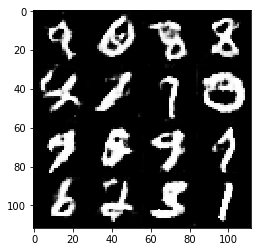

Epoch 0/2... Discriminator Loss: 1.0076... Generator Loss: 1.9946
Epoch 0/2... Discriminator Loss: 1.1919... Generator Loss: 1.2323
Epoch 0/2... Discriminator Loss: 1.3140... Generator Loss: 0.6687
Epoch 0/2... Discriminator Loss: 1.3577... Generator Loss: 0.5789
Epoch 0/2... Discriminator Loss: 1.4591... Generator Loss: 0.4784


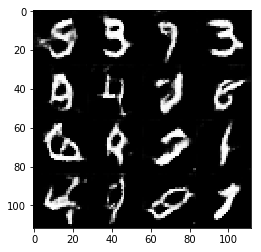

Epoch 0/2... Discriminator Loss: 1.8865... Generator Loss: 2.7622
Epoch 0/2... Discriminator Loss: 1.0867... Generator Loss: 1.0076
Epoch 0/2... Discriminator Loss: 2.2550... Generator Loss: 0.2104
Epoch 0/2... Discriminator Loss: 1.1507... Generator Loss: 0.7474
Epoch 0/2... Discriminator Loss: 1.2763... Generator Loss: 0.7066


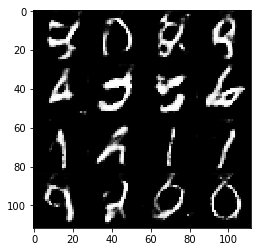

Epoch 0/2... Discriminator Loss: 1.0230... Generator Loss: 1.3420
Epoch 0/2... Discriminator Loss: 1.5901... Generator Loss: 0.3938
Epoch 0/2... Discriminator Loss: 2.3234... Generator Loss: 0.1966
Epoch 0/2... Discriminator Loss: 1.2425... Generator Loss: 0.7208
Epoch 0/2... Discriminator Loss: 1.6474... Generator Loss: 0.3998


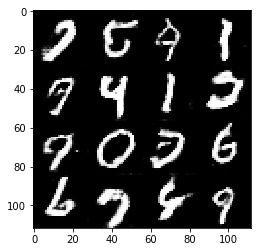

Epoch 0/2... Discriminator Loss: 1.0173... Generator Loss: 0.8782
Epoch 0/2... Discriminator Loss: 1.1271... Generator Loss: 1.3844
Epoch 0/2... Discriminator Loss: 1.3314... Generator Loss: 0.6791
Epoch 0/2... Discriminator Loss: 1.5463... Generator Loss: 2.2812
Epoch 0/2... Discriminator Loss: 1.6253... Generator Loss: 0.3827


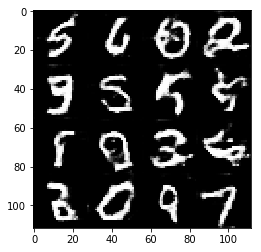

Epoch 0/2... Discriminator Loss: 1.2454... Generator Loss: 0.5859
Epoch 0/2... Discriminator Loss: 1.5090... Generator Loss: 0.4618
Epoch 0/2... Discriminator Loss: 0.9757... Generator Loss: 1.0894
Epoch 0/2... Discriminator Loss: 1.1240... Generator Loss: 1.9218
Epoch 0/2... Discriminator Loss: 1.0821... Generator Loss: 0.7854


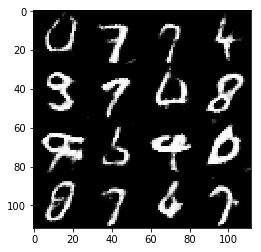

Epoch 0/2... Discriminator Loss: 1.6521... Generator Loss: 0.5438
Epoch 0/2... Discriminator Loss: 1.2320... Generator Loss: 0.7235
Epoch 0/2... Discriminator Loss: 1.1030... Generator Loss: 0.9407
Epoch 0/2... Discriminator Loss: 1.3458... Generator Loss: 0.6404
Epoch 0/2... Discriminator Loss: 1.2643... Generator Loss: 0.6349


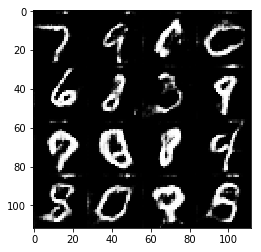

Epoch 0/2... Discriminator Loss: 1.0143... Generator Loss: 1.2436
Epoch 0/2... Discriminator Loss: 0.9133... Generator Loss: 1.2950
Epoch 0/2... Discriminator Loss: 0.9173... Generator Loss: 1.1357
Epoch 0/2... Discriminator Loss: 1.3396... Generator Loss: 0.5323
Epoch 0/2... Discriminator Loss: 0.7501... Generator Loss: 1.5145


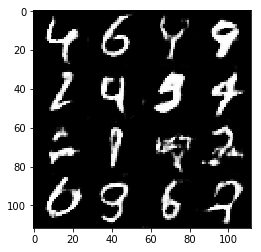

Epoch 0/2... Discriminator Loss: 1.7382... Generator Loss: 0.3641
Epoch 0/2... Discriminator Loss: 1.5028... Generator Loss: 0.4829
Epoch 0/2... Discriminator Loss: 1.2389... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.8658... Generator Loss: 0.3156


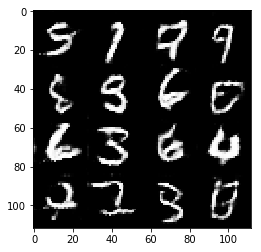

Epoch 1/2... Discriminator Loss: 1.9124... Generator Loss: 0.3319
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 1.6606
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.4564
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.5054


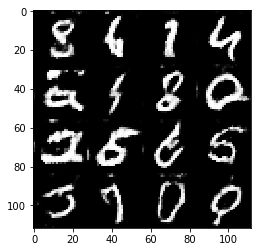

Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.4966
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 2.1613
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 0.9304


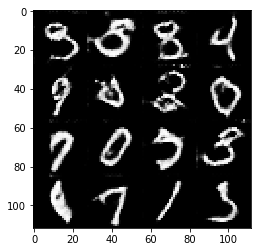

Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.4453
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.3492
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.3618


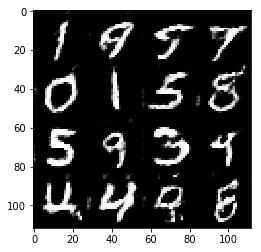

Epoch 1/2... Discriminator Loss: 1.6723... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 1.2752
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.6505
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.7073


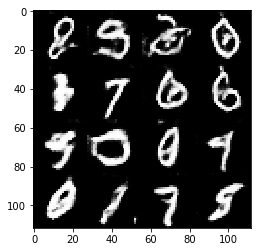

Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.5794
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 1.4100


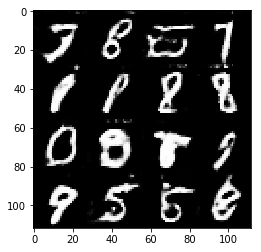

Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 2.0141
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.2153
Epoch 1/2... Discriminator Loss: 1.7153... Generator Loss: 0.3438
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.8286


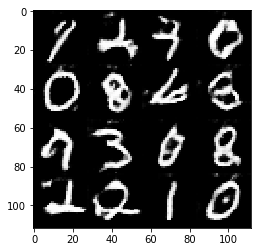

Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 0.8447
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.6689
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.7131


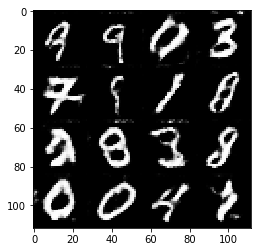

Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.3620
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 2.1145
Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 2.2249... Generator Loss: 0.2288


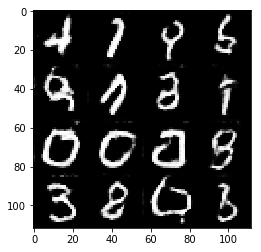

Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.3507
Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.1398


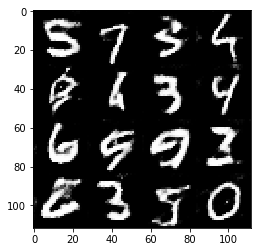

Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.4732
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.1355
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 2.3388
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.8663


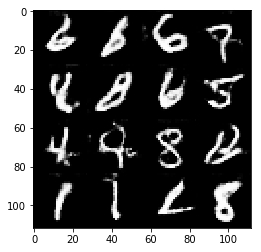

Epoch 1/2... Discriminator Loss: 0.8186... Generator Loss: 1.4972
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 1.5426
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.9104
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.0955


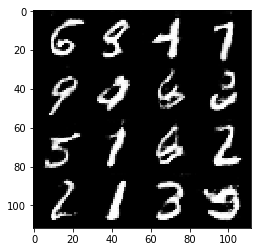

Epoch 1/2... Discriminator Loss: 1.1423... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 2.0086... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.6862... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.7865


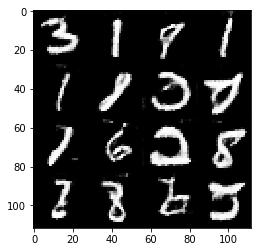

Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 2.2511
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 1.8539
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 1.1967


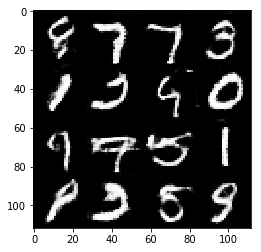

Epoch 1/2... Discriminator Loss: 1.6843... Generator Loss: 0.4167
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 1.2725
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 2.5696
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.8710


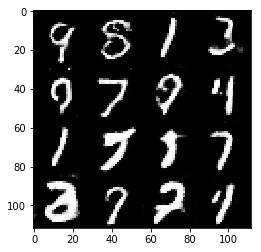

Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.3861
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.7296
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.4621


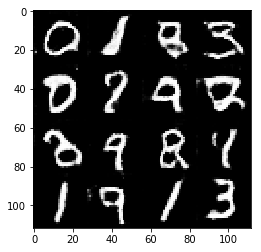

Epoch 1/2... Discriminator Loss: 2.2617... Generator Loss: 0.3228
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 1.1480
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 1.2059
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.7125
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.8190


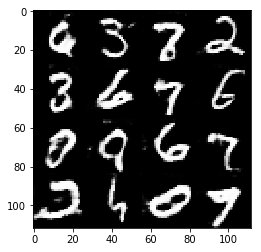

Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.4106
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 0.9941
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.6416
Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 1.3241


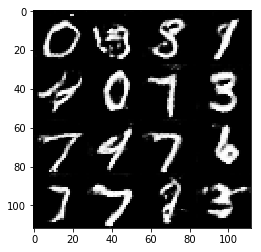

Epoch 1/2... Discriminator Loss: 2.2624... Generator Loss: 0.2390
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.0313
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.3401
Epoch 1/2... Discriminator Loss: 0.8481... Generator Loss: 1.1603
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 1.8077


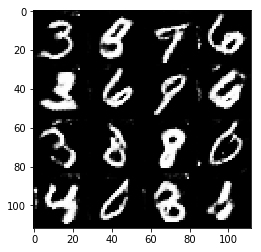

Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 2.7375... Generator Loss: 0.1984
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.7956
Epoch 1/2... Discriminator Loss: 1.5614... Generator Loss: 0.5277
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 2.0572


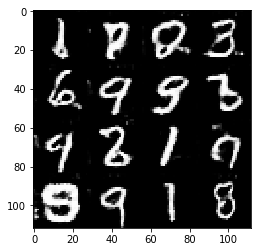

Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 2.1406
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 1.2636
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 0.9775
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.6970
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.5807


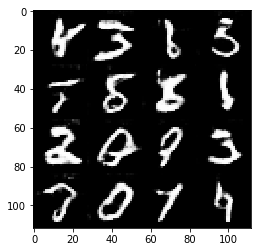

Epoch 1/2... Discriminator Loss: 0.7300... Generator Loss: 1.5180
Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.7721
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.6832
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.4748


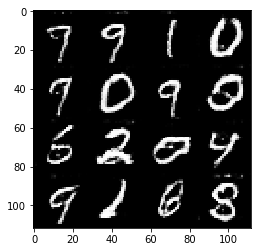

Epoch 1/2... Discriminator Loss: 2.1265... Generator Loss: 0.2393
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 2.3629
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 1.3814
Epoch 1/2... Discriminator Loss: 0.8050... Generator Loss: 1.2963


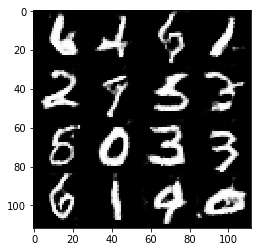

Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 2.2334
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 1.1887
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 1.3547
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 0.8582


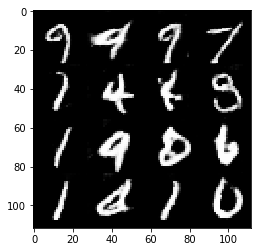

Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.7316
Epoch 1/2... Discriminator Loss: 1.8904... Generator Loss: 0.3847
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 0.7650... Generator Loss: 1.3940
Epoch 1/2... Discriminator Loss: 2.3018... Generator Loss: 0.2557


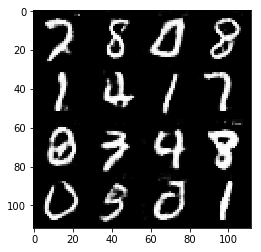

Epoch 1/2... Discriminator Loss: 1.8127... Generator Loss: 0.3526
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 0.8320... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.1404
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.5891


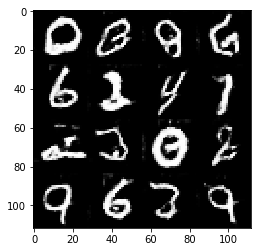

Epoch 1/2... Discriminator Loss: 2.1234... Generator Loss: 0.3013
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 2.0507... Generator Loss: 0.2758
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.8988


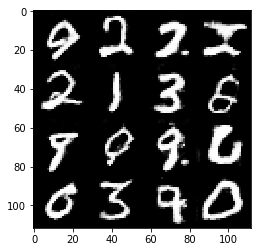

Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 2.0098
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.6511
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.0515
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.3469
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 0.7931


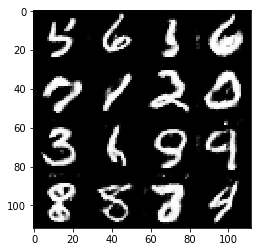

Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 1.8400
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.9357
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.5517


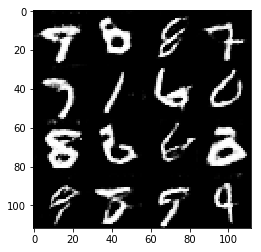

Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 1.5635
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 2.0510
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 0.9992


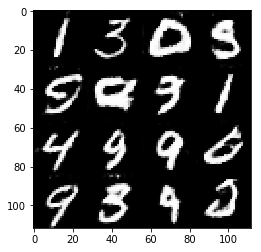

Epoch 1/2... Discriminator Loss: 0.8169... Generator Loss: 1.3788
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.8205
Epoch 1/2... Discriminator Loss: 2.3695... Generator Loss: 0.2680
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.1191
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 1.6742


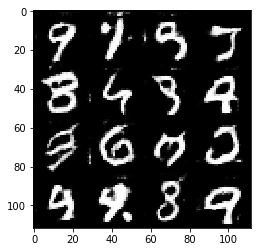

Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 1.4501
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 4.0506
Epoch 1/2... Discriminator Loss: 2.0746... Generator Loss: 0.3481
Epoch 1/2... Discriminator Loss: 2.1011... Generator Loss: 0.4704


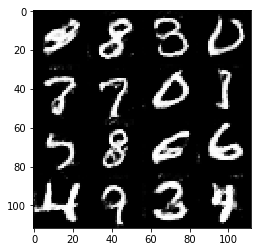

Epoch 1/2... Discriminator Loss: 0.8142... Generator Loss: 1.5073
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 1.0199
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.7528


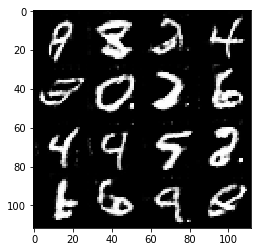

Epoch 1/2... Discriminator Loss: 1.6346... Generator Loss: 0.4468
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.7448... Generator Loss: 1.3371
Epoch 1/2... Discriminator Loss: 3.1727... Generator Loss: 0.1131
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.9305


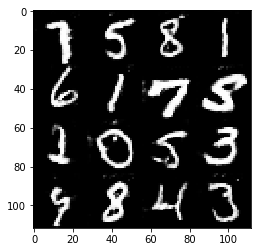

Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 2.3310
Epoch 1/2... Discriminator Loss: 2.6955... Generator Loss: 4.3031
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 2.3185
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 2.0636... Generator Loss: 0.3245


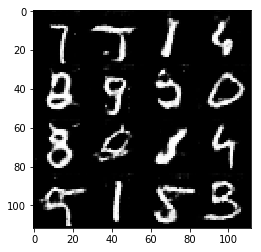

Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.6256... Generator Loss: 3.0853
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 1.0640
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.0481


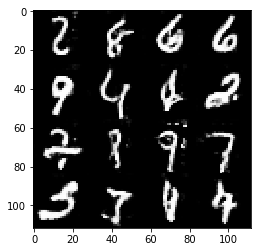

Epoch 1/2... Discriminator Loss: 0.8388... Generator Loss: 2.2198
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 2.8768
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.8602


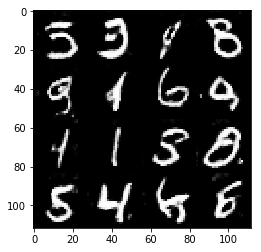

Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.6241
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 2.2914... Generator Loss: 0.2306
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.4554
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 0.9014


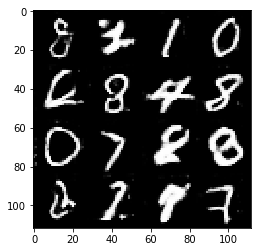

Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.9349


In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0/1... Discriminator Loss: 2.1745... Generator Loss: 0.3074
Epoch 0/1... Discriminator Loss: 0.6080... Generator Loss: 3.4734
Epoch 0/1... Discriminator Loss: 0.4838... Generator Loss: 4.9639
Epoch 0/1... Discriminator Loss: 0.8247... Generator Loss: 1.2624


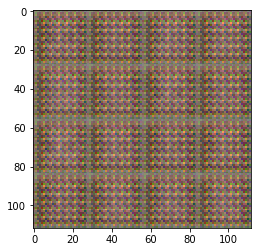

Epoch 0/1... Discriminator Loss: 0.5630... Generator Loss: 6.3850
Epoch 0/1... Discriminator Loss: 0.7530... Generator Loss: 1.6029
Epoch 0/1... Discriminator Loss: 0.7553... Generator Loss: 3.1946
Epoch 0/1... Discriminator Loss: 0.9580... Generator Loss: 6.3931
Epoch 0/1... Discriminator Loss: 0.7573... Generator Loss: 2.2364


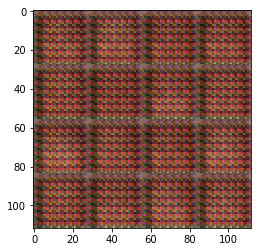

Epoch 0/1... Discriminator Loss: 0.7050... Generator Loss: 1.9388
Epoch 0/1... Discriminator Loss: 1.0350... Generator Loss: 2.7071
Epoch 0/1... Discriminator Loss: 0.7906... Generator Loss: 2.6370
Epoch 0/1... Discriminator Loss: 0.8640... Generator Loss: 1.7456
Epoch 0/1... Discriminator Loss: 1.1940... Generator Loss: 0.7741


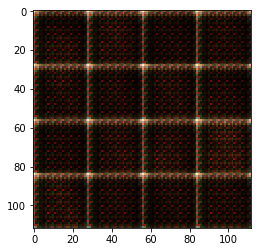

Epoch 0/1... Discriminator Loss: 0.8657... Generator Loss: 1.2651
Epoch 0/1... Discriminator Loss: 1.1690... Generator Loss: 0.7883
Epoch 0/1... Discriminator Loss: 0.9423... Generator Loss: 1.1555
Epoch 0/1... Discriminator Loss: 0.9805... Generator Loss: 1.7600
Epoch 0/1... Discriminator Loss: 1.0364... Generator Loss: 0.9577


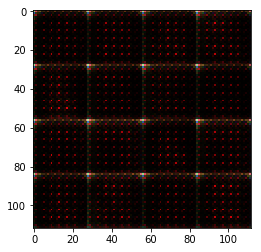

Epoch 0/1... Discriminator Loss: 1.6968... Generator Loss: 0.3596
Epoch 0/1... Discriminator Loss: 1.7607... Generator Loss: 3.7293
Epoch 0/1... Discriminator Loss: 1.6457... Generator Loss: 0.4192
Epoch 0/1... Discriminator Loss: 0.8164... Generator Loss: 1.5825
Epoch 0/1... Discriminator Loss: 1.8436... Generator Loss: 0.3984


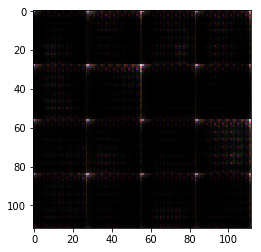

Epoch 0/1... Discriminator Loss: 1.1290... Generator Loss: 0.9214
Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 1.4492
Epoch 0/1... Discriminator Loss: 1.1511... Generator Loss: 1.2971
Epoch 0/1... Discriminator Loss: 1.2518... Generator Loss: 1.0837
Epoch 0/1... Discriminator Loss: 1.2847... Generator Loss: 0.7842


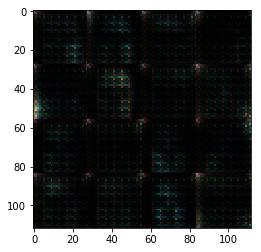

Epoch 0/1... Discriminator Loss: 1.7774... Generator Loss: 0.3702
Epoch 0/1... Discriminator Loss: 1.0863... Generator Loss: 1.3299
Epoch 0/1... Discriminator Loss: 1.2042... Generator Loss: 0.7926
Epoch 0/1... Discriminator Loss: 1.2173... Generator Loss: 2.0242
Epoch 0/1... Discriminator Loss: 1.2353... Generator Loss: 0.7275


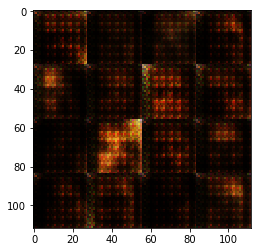

Epoch 0/1... Discriminator Loss: 1.7419... Generator Loss: 0.3711
Epoch 0/1... Discriminator Loss: 1.3172... Generator Loss: 0.6308
Epoch 0/1... Discriminator Loss: 1.2952... Generator Loss: 1.2451
Epoch 0/1... Discriminator Loss: 1.3056... Generator Loss: 0.6906
Epoch 0/1... Discriminator Loss: 1.5812... Generator Loss: 0.5821


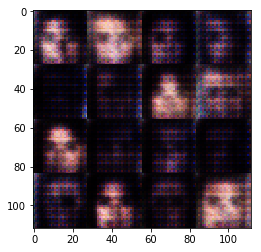

Epoch 0/1... Discriminator Loss: 1.2828... Generator Loss: 0.7000
Epoch 0/1... Discriminator Loss: 1.4555... Generator Loss: 0.7815
Epoch 0/1... Discriminator Loss: 1.8982... Generator Loss: 0.2703
Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 1.0702
Epoch 0/1... Discriminator Loss: 1.2855... Generator Loss: 0.8456


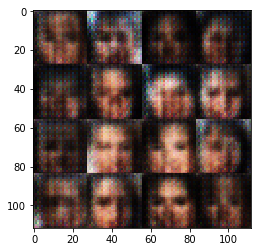

Epoch 0/1... Discriminator Loss: 1.3948... Generator Loss: 0.8368
Epoch 0/1... Discriminator Loss: 1.2247... Generator Loss: 1.2478
Epoch 0/1... Discriminator Loss: 1.6882... Generator Loss: 0.4436
Epoch 0/1... Discriminator Loss: 1.0357... Generator Loss: 1.0326
Epoch 0/1... Discriminator Loss: 1.5596... Generator Loss: 0.5825


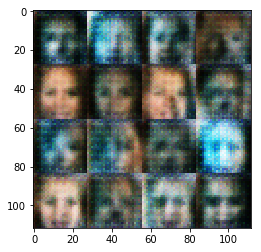

Epoch 0/1... Discriminator Loss: 1.2927... Generator Loss: 0.9977
Epoch 0/1... Discriminator Loss: 1.2451... Generator Loss: 1.3035
Epoch 0/1... Discriminator Loss: 1.5185... Generator Loss: 0.5546
Epoch 0/1... Discriminator Loss: 1.1036... Generator Loss: 0.9308
Epoch 0/1... Discriminator Loss: 1.4104... Generator Loss: 0.7262


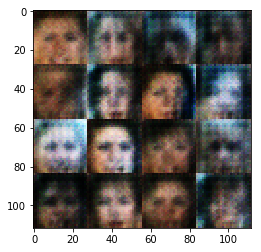

Epoch 0/1... Discriminator Loss: 1.2895... Generator Loss: 0.7115
Epoch 0/1... Discriminator Loss: 1.2301... Generator Loss: 1.0634
Epoch 0/1... Discriminator Loss: 1.5406... Generator Loss: 0.5226
Epoch 0/1... Discriminator Loss: 1.0218... Generator Loss: 1.8735
Epoch 0/1... Discriminator Loss: 1.0202... Generator Loss: 1.4828


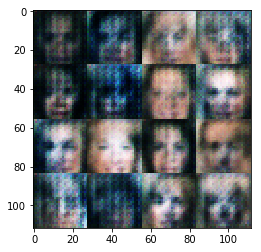

Epoch 0/1... Discriminator Loss: 1.6194... Generator Loss: 0.6374
Epoch 0/1... Discriminator Loss: 1.1340... Generator Loss: 0.9928
Epoch 0/1... Discriminator Loss: 1.3376... Generator Loss: 0.7168
Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 0.9382
Epoch 0/1... Discriminator Loss: 1.4003... Generator Loss: 0.9630


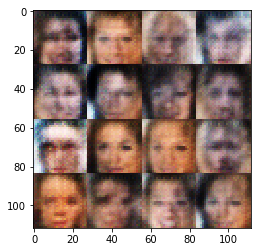

Epoch 0/1... Discriminator Loss: 1.5437... Generator Loss: 0.5017
Epoch 0/1... Discriminator Loss: 1.2457... Generator Loss: 0.9087
Epoch 0/1... Discriminator Loss: 1.1452... Generator Loss: 0.9458
Epoch 0/1... Discriminator Loss: 1.2825... Generator Loss: 0.7827
Epoch 0/1... Discriminator Loss: 1.3263... Generator Loss: 0.6829


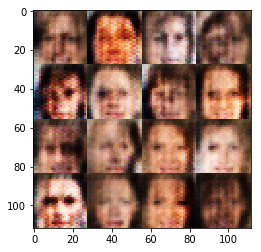

Epoch 0/1... Discriminator Loss: 1.4572... Generator Loss: 0.7032
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 1.1457
Epoch 0/1... Discriminator Loss: 1.3431... Generator Loss: 1.0249
Epoch 0/1... Discriminator Loss: 1.3261... Generator Loss: 0.8747
Epoch 0/1... Discriminator Loss: 1.2726... Generator Loss: 0.9654


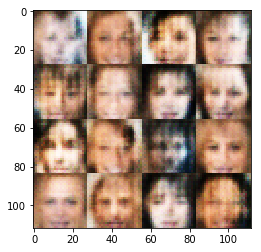

Epoch 0/1... Discriminator Loss: 1.3678... Generator Loss: 0.8495
Epoch 0/1... Discriminator Loss: 1.4465... Generator Loss: 0.6477
Epoch 0/1... Discriminator Loss: 1.2004... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.1950... Generator Loss: 0.9677
Epoch 0/1... Discriminator Loss: 1.3431... Generator Loss: 0.7238


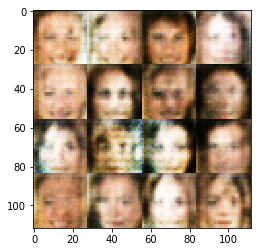

Epoch 0/1... Discriminator Loss: 1.2486... Generator Loss: 0.9791
Epoch 0/1... Discriminator Loss: 1.1898... Generator Loss: 0.9770
Epoch 0/1... Discriminator Loss: 1.5166... Generator Loss: 0.6297
Epoch 0/1... Discriminator Loss: 1.3703... Generator Loss: 0.6331
Epoch 0/1... Discriminator Loss: 1.3619... Generator Loss: 0.8185


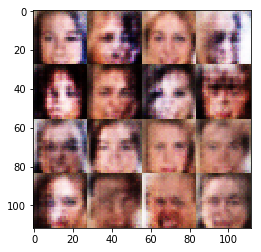

Epoch 0/1... Discriminator Loss: 1.3134... Generator Loss: 0.9037
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 0.7912
Epoch 0/1... Discriminator Loss: 1.3629... Generator Loss: 0.7621
Epoch 0/1... Discriminator Loss: 1.2936... Generator Loss: 0.7853
Epoch 0/1... Discriminator Loss: 1.2362... Generator Loss: 0.8354


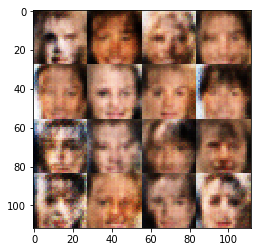

Epoch 0/1... Discriminator Loss: 1.3823... Generator Loss: 0.6351
Epoch 0/1... Discriminator Loss: 1.3514... Generator Loss: 0.9376
Epoch 0/1... Discriminator Loss: 1.3212... Generator Loss: 0.8987
Epoch 0/1... Discriminator Loss: 1.4956... Generator Loss: 0.5815
Epoch 0/1... Discriminator Loss: 1.5161... Generator Loss: 0.7490


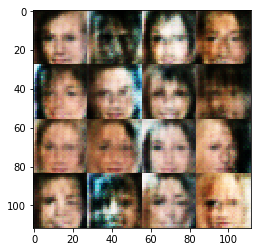

Epoch 0/1... Discriminator Loss: 1.1884... Generator Loss: 0.7977
Epoch 0/1... Discriminator Loss: 1.5263... Generator Loss: 0.8156
Epoch 0/1... Discriminator Loss: 1.1903... Generator Loss: 1.0416
Epoch 0/1... Discriminator Loss: 1.1865... Generator Loss: 1.1310
Epoch 0/1... Discriminator Loss: 1.4632... Generator Loss: 0.7820


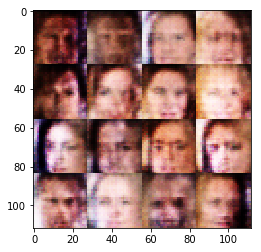

Epoch 0/1... Discriminator Loss: 1.2054... Generator Loss: 0.9194
Epoch 0/1... Discriminator Loss: 1.1012... Generator Loss: 1.2055
Epoch 0/1... Discriminator Loss: 1.6640... Generator Loss: 0.5111
Epoch 0/1... Discriminator Loss: 1.4316... Generator Loss: 0.6271
Epoch 0/1... Discriminator Loss: 1.2473... Generator Loss: 0.9248


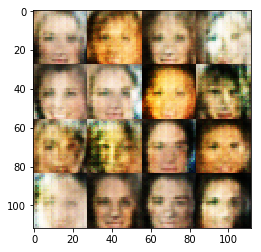

Epoch 0/1... Discriminator Loss: 1.2490... Generator Loss: 0.8200
Epoch 0/1... Discriminator Loss: 1.3470... Generator Loss: 0.8400
Epoch 0/1... Discriminator Loss: 1.1302... Generator Loss: 0.9196
Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.9521
Epoch 0/1... Discriminator Loss: 1.3383... Generator Loss: 0.7737


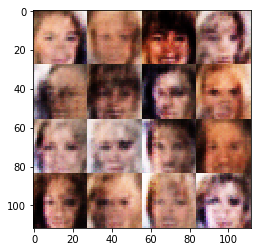

Epoch 0/1... Discriminator Loss: 1.4838... Generator Loss: 0.6311
Epoch 0/1... Discriminator Loss: 1.4294... Generator Loss: 0.7949
Epoch 0/1... Discriminator Loss: 1.5431... Generator Loss: 0.7000
Epoch 0/1... Discriminator Loss: 1.3600... Generator Loss: 0.9103
Epoch 0/1... Discriminator Loss: 1.2015... Generator Loss: 0.8583


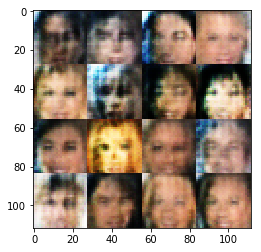

Epoch 0/1... Discriminator Loss: 1.3012... Generator Loss: 0.7400
Epoch 0/1... Discriminator Loss: 1.4721... Generator Loss: 0.7688
Epoch 0/1... Discriminator Loss: 1.4096... Generator Loss: 0.8726
Epoch 0/1... Discriminator Loss: 1.2952... Generator Loss: 0.8201
Epoch 0/1... Discriminator Loss: 1.4347... Generator Loss: 0.7146


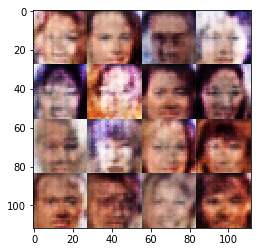

Epoch 0/1... Discriminator Loss: 1.4138... Generator Loss: 0.6208
Epoch 0/1... Discriminator Loss: 1.2953... Generator Loss: 0.6607
Epoch 0/1... Discriminator Loss: 1.4392... Generator Loss: 1.0690
Epoch 0/1... Discriminator Loss: 1.1388... Generator Loss: 0.8429
Epoch 0/1... Discriminator Loss: 1.3988... Generator Loss: 0.7048


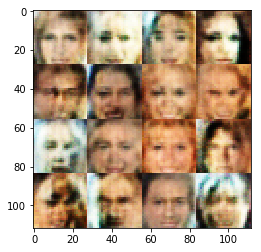

Epoch 0/1... Discriminator Loss: 1.3868... Generator Loss: 0.6581
Epoch 0/1... Discriminator Loss: 1.2405... Generator Loss: 0.9214
Epoch 0/1... Discriminator Loss: 1.7418... Generator Loss: 0.5270
Epoch 0/1... Discriminator Loss: 1.3436... Generator Loss: 0.8271
Epoch 0/1... Discriminator Loss: 1.6393... Generator Loss: 0.7306


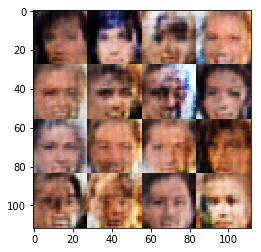

Epoch 0/1... Discriminator Loss: 1.0332... Generator Loss: 1.0004
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.7734
Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 0.9666
Epoch 0/1... Discriminator Loss: 1.3353... Generator Loss: 0.6628
Epoch 0/1... Discriminator Loss: 1.1399... Generator Loss: 0.9100


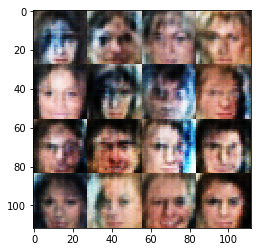

Epoch 0/1... Discriminator Loss: 1.1220... Generator Loss: 0.9872
Epoch 0/1... Discriminator Loss: 1.3528... Generator Loss: 0.7373
Epoch 0/1... Discriminator Loss: 1.5409... Generator Loss: 0.4801
Epoch 0/1... Discriminator Loss: 1.3546... Generator Loss: 1.0100
Epoch 0/1... Discriminator Loss: 1.3237... Generator Loss: 0.7337


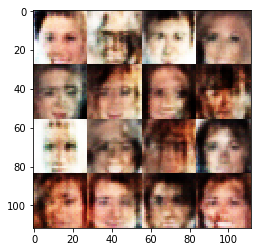

Epoch 0/1... Discriminator Loss: 1.2576... Generator Loss: 0.7993
Epoch 0/1... Discriminator Loss: 1.2931... Generator Loss: 0.8824
Epoch 0/1... Discriminator Loss: 1.2332... Generator Loss: 0.7064
Epoch 0/1... Discriminator Loss: 1.3042... Generator Loss: 0.9285
Epoch 0/1... Discriminator Loss: 1.3680... Generator Loss: 0.6113


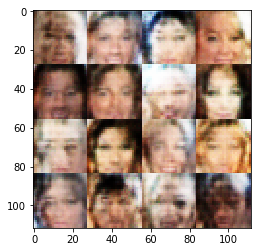

Epoch 0/1... Discriminator Loss: 1.0994... Generator Loss: 1.1274
Epoch 0/1... Discriminator Loss: 1.3179... Generator Loss: 1.4475
Epoch 0/1... Discriminator Loss: 1.1598... Generator Loss: 0.9261
Epoch 0/1... Discriminator Loss: 1.4215... Generator Loss: 0.7635
Epoch 0/1... Discriminator Loss: 1.3651... Generator Loss: 0.8744


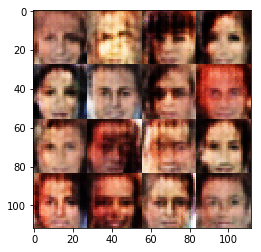

Epoch 0/1... Discriminator Loss: 1.2253... Generator Loss: 0.7991
Epoch 0/1... Discriminator Loss: 1.0716... Generator Loss: 1.0719
Epoch 0/1... Discriminator Loss: 1.2845... Generator Loss: 0.6848
Epoch 0/1... Discriminator Loss: 1.1422... Generator Loss: 0.9768
Epoch 0/1... Discriminator Loss: 1.2072... Generator Loss: 1.1467


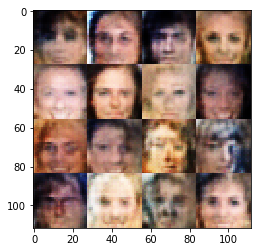

Epoch 0/1... Discriminator Loss: 1.2693... Generator Loss: 0.8091
Epoch 0/1... Discriminator Loss: 1.5138... Generator Loss: 0.4652
Epoch 0/1... Discriminator Loss: 1.2872... Generator Loss: 1.0131
Epoch 0/1... Discriminator Loss: 1.3894... Generator Loss: 0.5203
Epoch 0/1... Discriminator Loss: 1.1128... Generator Loss: 0.9455


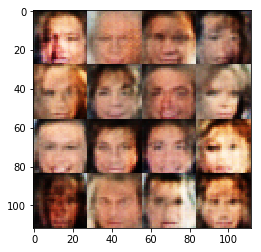

Epoch 0/1... Discriminator Loss: 1.2563... Generator Loss: 0.6980
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 1.3550
Epoch 0/1... Discriminator Loss: 1.0593... Generator Loss: 0.9431
Epoch 0/1... Discriminator Loss: 1.8624... Generator Loss: 0.2937
Epoch 0/1... Discriminator Loss: 1.1059... Generator Loss: 1.2769


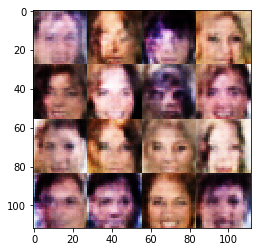

Epoch 0/1... Discriminator Loss: 1.3794... Generator Loss: 0.6489
Epoch 0/1... Discriminator Loss: 1.0830... Generator Loss: 1.5421
Epoch 0/1... Discriminator Loss: 1.2664... Generator Loss: 2.1930
Epoch 0/1... Discriminator Loss: 1.2504... Generator Loss: 0.7182
Epoch 0/1... Discriminator Loss: 1.3152... Generator Loss: 0.7274


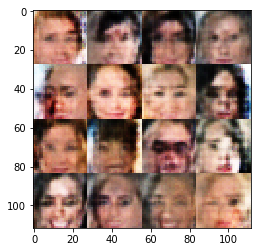

Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 1.1651
Epoch 0/1... Discriminator Loss: 1.3691... Generator Loss: 0.6477
Epoch 0/1... Discriminator Loss: 1.2608... Generator Loss: 0.7304
Epoch 0/1... Discriminator Loss: 1.3160... Generator Loss: 0.6055
Epoch 0/1... Discriminator Loss: 1.1992... Generator Loss: 0.7783


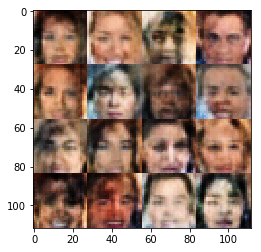

Epoch 0/1... Discriminator Loss: 1.2791... Generator Loss: 0.7315
Epoch 0/1... Discriminator Loss: 1.0966... Generator Loss: 1.1415
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.9887
Epoch 0/1... Discriminator Loss: 1.1969... Generator Loss: 1.1642
Epoch 0/1... Discriminator Loss: 1.2766... Generator Loss: 0.9640


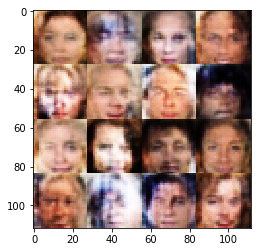

Epoch 0/1... Discriminator Loss: 1.2969... Generator Loss: 0.8722
Epoch 0/1... Discriminator Loss: 1.1406... Generator Loss: 1.0475
Epoch 0/1... Discriminator Loss: 1.3045... Generator Loss: 0.9607
Epoch 0/1... Discriminator Loss: 1.1836... Generator Loss: 0.9691
Epoch 0/1... Discriminator Loss: 1.2775... Generator Loss: 0.6511


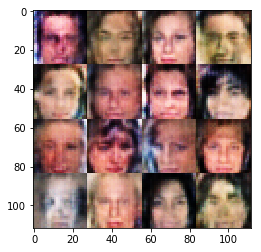

Epoch 0/1... Discriminator Loss: 1.1179... Generator Loss: 0.8772
Epoch 0/1... Discriminator Loss: 1.0348... Generator Loss: 1.3864
Epoch 0/1... Discriminator Loss: 1.2671... Generator Loss: 0.6805
Epoch 0/1... Discriminator Loss: 1.3353... Generator Loss: 0.6001
Epoch 0/1... Discriminator Loss: 1.3247... Generator Loss: 1.4829


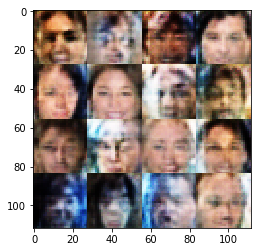

Epoch 0/1... Discriminator Loss: 1.1342... Generator Loss: 0.7894
Epoch 0/1... Discriminator Loss: 1.1360... Generator Loss: 0.8200
Epoch 0/1... Discriminator Loss: 1.7339... Generator Loss: 0.3645
Epoch 0/1... Discriminator Loss: 1.1385... Generator Loss: 0.9819
Epoch 0/1... Discriminator Loss: 1.1826... Generator Loss: 1.0138


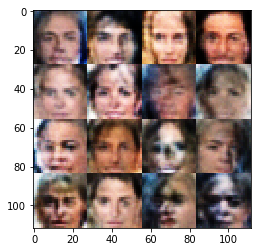

Epoch 0/1... Discriminator Loss: 1.1622... Generator Loss: 0.8758
Epoch 0/1... Discriminator Loss: 1.4128... Generator Loss: 0.5314
Epoch 0/1... Discriminator Loss: 1.1178... Generator Loss: 1.0590
Epoch 0/1... Discriminator Loss: 1.5118... Generator Loss: 0.9821
Epoch 0/1... Discriminator Loss: 1.5717... Generator Loss: 1.1414


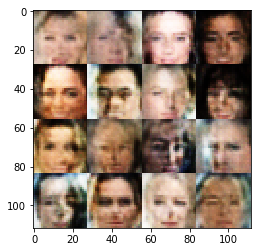

Epoch 0/1... Discriminator Loss: 1.6052... Generator Loss: 0.4379
Epoch 0/1... Discriminator Loss: 1.4152... Generator Loss: 0.6884
Epoch 0/1... Discriminator Loss: 1.2983... Generator Loss: 0.6553
Epoch 0/1... Discriminator Loss: 1.0849... Generator Loss: 1.2625
Epoch 0/1... Discriminator Loss: 1.4774... Generator Loss: 0.7644


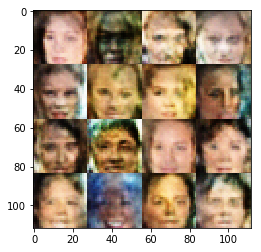

Epoch 0/1... Discriminator Loss: 1.4943... Generator Loss: 0.4813
Epoch 0/1... Discriminator Loss: 1.4349... Generator Loss: 0.8640
Epoch 0/1... Discriminator Loss: 1.1114... Generator Loss: 0.8178
Epoch 0/1... Discriminator Loss: 1.1560... Generator Loss: 0.7824
Epoch 0/1... Discriminator Loss: 1.1232... Generator Loss: 0.9063


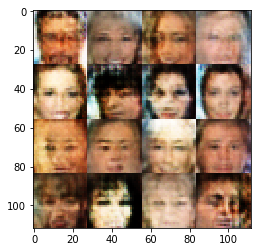

Epoch 0/1... Discriminator Loss: 1.2913... Generator Loss: 0.7177
Epoch 0/1... Discriminator Loss: 1.3373... Generator Loss: 0.6040
Epoch 0/1... Discriminator Loss: 1.3847... Generator Loss: 0.5776
Epoch 0/1... Discriminator Loss: 1.2480... Generator Loss: 0.8120
Epoch 0/1... Discriminator Loss: 1.2827... Generator Loss: 0.6331


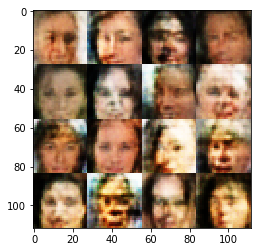

Epoch 0/1... Discriminator Loss: 1.3119... Generator Loss: 0.7435
Epoch 0/1... Discriminator Loss: 1.6191... Generator Loss: 0.4882
Epoch 0/1... Discriminator Loss: 1.2448... Generator Loss: 0.8152
Epoch 0/1... Discriminator Loss: 1.1977... Generator Loss: 1.0244
Epoch 0/1... Discriminator Loss: 1.1992... Generator Loss: 0.8238


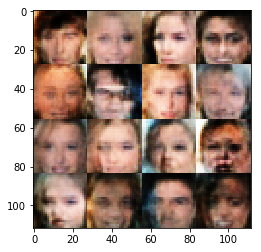

Epoch 0/1... Discriminator Loss: 1.2271... Generator Loss: 0.7677
Epoch 0/1... Discriminator Loss: 1.2440... Generator Loss: 0.7127
Epoch 0/1... Discriminator Loss: 1.1548... Generator Loss: 0.7409
Epoch 0/1... Discriminator Loss: 1.4642... Generator Loss: 0.6178
Epoch 0/1... Discriminator Loss: 1.3070... Generator Loss: 0.8110


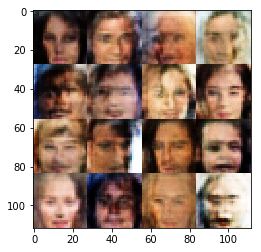

Epoch 0/1... Discriminator Loss: 1.0838... Generator Loss: 0.9745
Epoch 0/1... Discriminator Loss: 1.2380... Generator Loss: 1.0334
Epoch 0/1... Discriminator Loss: 1.2738... Generator Loss: 0.8993
Epoch 0/1... Discriminator Loss: 1.3727... Generator Loss: 0.6546
Epoch 0/1... Discriminator Loss: 1.3714... Generator Loss: 0.7563


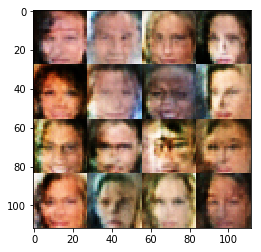

Epoch 0/1... Discriminator Loss: 1.1892... Generator Loss: 1.1334
Epoch 0/1... Discriminator Loss: 1.2579... Generator Loss: 0.9774
Epoch 0/1... Discriminator Loss: 1.1102... Generator Loss: 1.3808
Epoch 0/1... Discriminator Loss: 1.3617... Generator Loss: 1.3041
Epoch 0/1... Discriminator Loss: 1.3001... Generator Loss: 0.6470


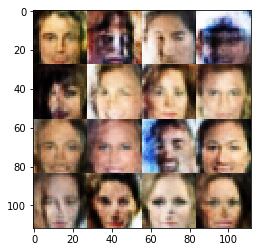

Epoch 0/1... Discriminator Loss: 1.1791... Generator Loss: 0.8033
Epoch 0/1... Discriminator Loss: 1.3488... Generator Loss: 0.6348
Epoch 0/1... Discriminator Loss: 1.1781... Generator Loss: 0.7301
Epoch 0/1... Discriminator Loss: 1.1359... Generator Loss: 0.8950
Epoch 0/1... Discriminator Loss: 1.1542... Generator Loss: 0.7854


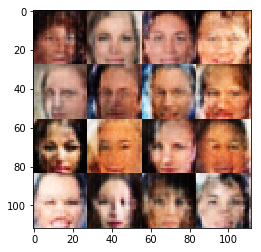

Epoch 0/1... Discriminator Loss: 1.0454... Generator Loss: 1.1602
Epoch 0/1... Discriminator Loss: 0.9459... Generator Loss: 1.0484
Epoch 0/1... Discriminator Loss: 1.0710... Generator Loss: 0.8426
Epoch 0/1... Discriminator Loss: 1.1509... Generator Loss: 1.3928
Epoch 0/1... Discriminator Loss: 1.1277... Generator Loss: 0.8924


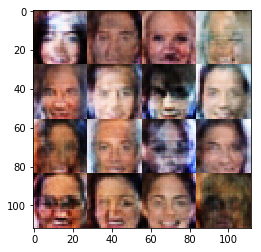

Epoch 0/1... Discriminator Loss: 1.1806... Generator Loss: 0.7961
Epoch 0/1... Discriminator Loss: 1.3828... Generator Loss: 0.6468
Epoch 0/1... Discriminator Loss: 1.1886... Generator Loss: 1.0612
Epoch 0/1... Discriminator Loss: 1.1247... Generator Loss: 1.0927
Epoch 0/1... Discriminator Loss: 1.2025... Generator Loss: 1.0902


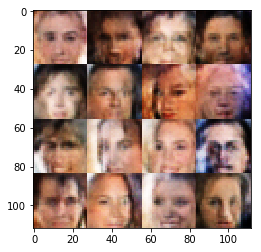

Epoch 0/1... Discriminator Loss: 1.3597... Generator Loss: 0.6332
Epoch 0/1... Discriminator Loss: 1.3196... Generator Loss: 0.6377
Epoch 0/1... Discriminator Loss: 1.6865... Generator Loss: 0.4065
Epoch 0/1... Discriminator Loss: 1.3926... Generator Loss: 0.8932
Epoch 0/1... Discriminator Loss: 0.9575... Generator Loss: 1.1479


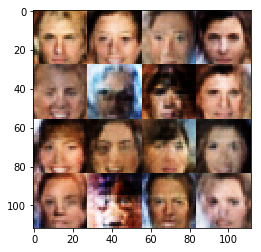

Epoch 0/1... Discriminator Loss: 1.1362... Generator Loss: 1.0363
Epoch 0/1... Discriminator Loss: 1.3188... Generator Loss: 0.6883
Epoch 0/1... Discriminator Loss: 1.2322... Generator Loss: 0.6751
Epoch 0/1... Discriminator Loss: 1.2492... Generator Loss: 0.7860
Epoch 0/1... Discriminator Loss: 1.5535... Generator Loss: 0.4209


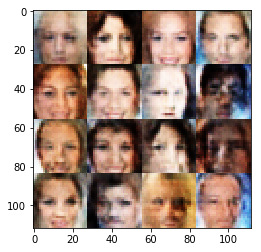

Epoch 0/1... Discriminator Loss: 1.4619... Generator Loss: 0.7173
Epoch 0/1... Discriminator Loss: 1.2181... Generator Loss: 0.7688
Epoch 0/1... Discriminator Loss: 0.9896... Generator Loss: 1.6587
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 0.6081
Epoch 0/1... Discriminator Loss: 1.4208... Generator Loss: 0.8178


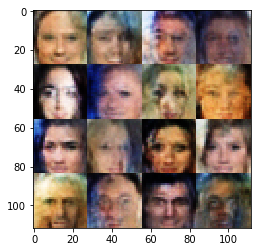

Epoch 0/1... Discriminator Loss: 1.2862... Generator Loss: 0.7802
Epoch 0/1... Discriminator Loss: 1.1792... Generator Loss: 1.1880
Epoch 0/1... Discriminator Loss: 1.4122... Generator Loss: 0.5842
Epoch 0/1... Discriminator Loss: 1.5078... Generator Loss: 0.4920
Epoch 0/1... Discriminator Loss: 1.2512... Generator Loss: 0.7357


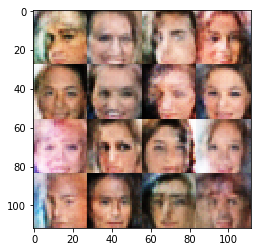

Epoch 0/1... Discriminator Loss: 1.1950... Generator Loss: 1.4867
Epoch 0/1... Discriminator Loss: 1.1756... Generator Loss: 0.9154
Epoch 0/1... Discriminator Loss: 1.0991... Generator Loss: 1.0614
Epoch 0/1... Discriminator Loss: 1.1724... Generator Loss: 0.9487
Epoch 0/1... Discriminator Loss: 1.2422... Generator Loss: 1.0218


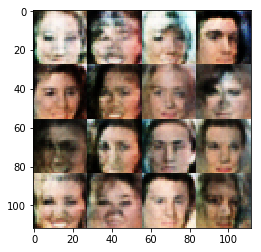

Epoch 0/1... Discriminator Loss: 1.2107... Generator Loss: 0.7148
Epoch 0/1... Discriminator Loss: 1.0260... Generator Loss: 1.3064
Epoch 0/1... Discriminator Loss: 1.2574... Generator Loss: 0.8040
Epoch 0/1... Discriminator Loss: 1.6018... Generator Loss: 0.4038
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 1.0739


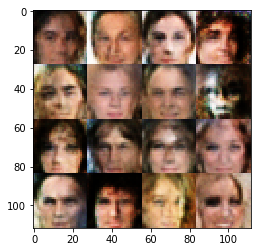

Epoch 0/1... Discriminator Loss: 1.1963... Generator Loss: 0.7867
Epoch 0/1... Discriminator Loss: 1.1521... Generator Loss: 0.7909
Epoch 0/1... Discriminator Loss: 1.2150... Generator Loss: 0.8634
Epoch 0/1... Discriminator Loss: 1.0612... Generator Loss: 1.1282
Epoch 0/1... Discriminator Loss: 1.4911... Generator Loss: 0.5306


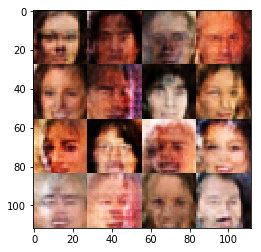

Epoch 0/1... Discriminator Loss: 1.1321... Generator Loss: 0.8753
Epoch 0/1... Discriminator Loss: 1.5912... Generator Loss: 0.5223
Epoch 0/1... Discriminator Loss: 1.2947... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 1.2329... Generator Loss: 0.7720
Epoch 0/1... Discriminator Loss: 1.1808... Generator Loss: 0.8304


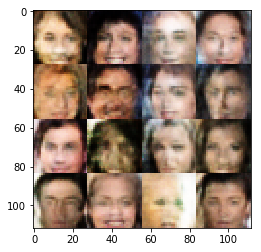

Epoch 0/1... Discriminator Loss: 1.0858... Generator Loss: 1.0112
Epoch 0/1... Discriminator Loss: 1.3897... Generator Loss: 0.6273
Epoch 0/1... Discriminator Loss: 1.3508... Generator Loss: 0.7585
Epoch 0/1... Discriminator Loss: 1.3110... Generator Loss: 0.7788
Epoch 0/1... Discriminator Loss: 1.3624... Generator Loss: 0.7262


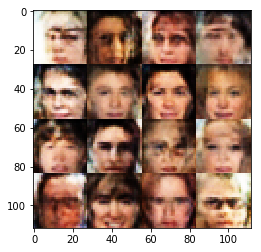

Epoch 0/1... Discriminator Loss: 1.2157... Generator Loss: 0.7088
Epoch 0/1... Discriminator Loss: 1.0802... Generator Loss: 0.9872
Epoch 0/1... Discriminator Loss: 1.1631... Generator Loss: 0.9125
Epoch 0/1... Discriminator Loss: 1.1242... Generator Loss: 1.1836
Epoch 0/1... Discriminator Loss: 1.4249... Generator Loss: 0.6105


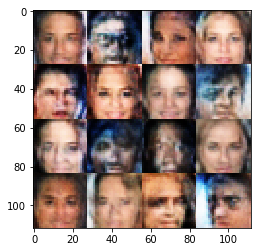

Epoch 0/1... Discriminator Loss: 1.2745... Generator Loss: 0.7506
Epoch 0/1... Discriminator Loss: 1.2902... Generator Loss: 0.6485
Epoch 0/1... Discriminator Loss: 1.1265... Generator Loss: 0.8935
Epoch 0/1... Discriminator Loss: 1.1447... Generator Loss: 0.8363
Epoch 0/1... Discriminator Loss: 1.1973... Generator Loss: 0.7510


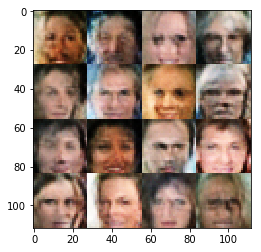

Epoch 0/1... Discriminator Loss: 1.4533... Generator Loss: 0.4862
Epoch 0/1... Discriminator Loss: 1.5665... Generator Loss: 0.4605
Epoch 0/1... Discriminator Loss: 1.4759... Generator Loss: 0.5215
Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 0.9793
Epoch 0/1... Discriminator Loss: 1.1158... Generator Loss: 0.9434


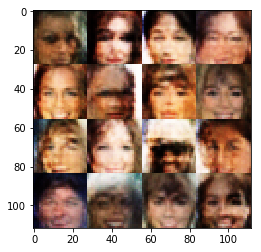

Epoch 0/1... Discriminator Loss: 1.2547... Generator Loss: 1.0304
Epoch 0/1... Discriminator Loss: 1.3703... Generator Loss: 0.8336
Epoch 0/1... Discriminator Loss: 1.1664... Generator Loss: 0.8803
Epoch 0/1... Discriminator Loss: 1.3225... Generator Loss: 0.8524
Epoch 0/1... Discriminator Loss: 1.1075... Generator Loss: 0.9552


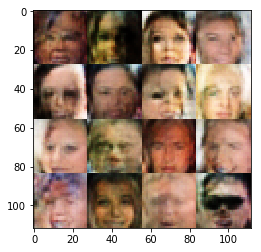

Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 1.4229
Epoch 0/1... Discriminator Loss: 1.3343... Generator Loss: 0.5398
Epoch 0/1... Discriminator Loss: 1.0395... Generator Loss: 1.0032
Epoch 0/1... Discriminator Loss: 1.1859... Generator Loss: 0.8548
Epoch 0/1... Discriminator Loss: 1.0913... Generator Loss: 0.9037


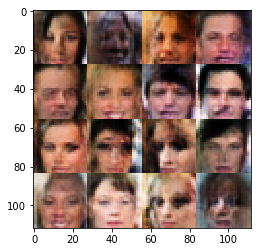

Epoch 0/1... Discriminator Loss: 1.2387... Generator Loss: 0.8098
Epoch 0/1... Discriminator Loss: 1.1607... Generator Loss: 0.7638
Epoch 0/1... Discriminator Loss: 1.3166... Generator Loss: 0.7483
Epoch 0/1... Discriminator Loss: 1.4705... Generator Loss: 0.7008
Epoch 0/1... Discriminator Loss: 1.2646... Generator Loss: 0.7599


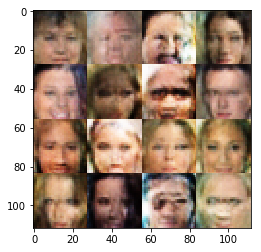

Epoch 0/1... Discriminator Loss: 1.2572... Generator Loss: 0.7931
Epoch 0/1... Discriminator Loss: 1.3304... Generator Loss: 0.6873
Epoch 0/1... Discriminator Loss: 1.2675... Generator Loss: 1.0242
Epoch 0/1... Discriminator Loss: 1.2539... Generator Loss: 0.6972
Epoch 0/1... Discriminator Loss: 1.2752... Generator Loss: 0.7630


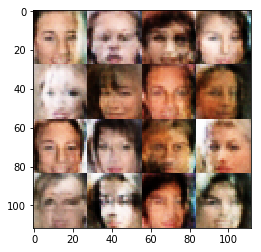

Epoch 0/1... Discriminator Loss: 1.1487... Generator Loss: 1.1443
Epoch 0/1... Discriminator Loss: 0.9982... Generator Loss: 1.4106
Epoch 0/1... Discriminator Loss: 1.3992... Generator Loss: 0.7560
Epoch 0/1... Discriminator Loss: 1.5682... Generator Loss: 0.4390
Epoch 0/1... Discriminator Loss: 1.4864... Generator Loss: 0.4918


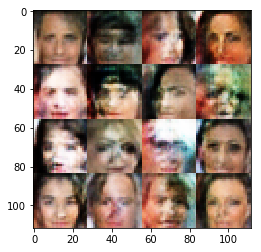

Epoch 0/1... Discriminator Loss: 1.3968... Generator Loss: 0.6591
Epoch 0/1... Discriminator Loss: 1.2993... Generator Loss: 0.8101
Epoch 0/1... Discriminator Loss: 1.1867... Generator Loss: 0.7100
Epoch 0/1... Discriminator Loss: 1.3415... Generator Loss: 0.7324
Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 0.6634


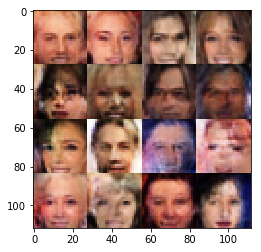

Epoch 0/1... Discriminator Loss: 1.3184... Generator Loss: 0.6927
Epoch 0/1... Discriminator Loss: 1.3550... Generator Loss: 1.0737
Epoch 0/1... Discriminator Loss: 1.4145... Generator Loss: 0.5799
Epoch 0/1... Discriminator Loss: 1.3098... Generator Loss: 0.7510
Epoch 0/1... Discriminator Loss: 1.5233... Generator Loss: 0.5975


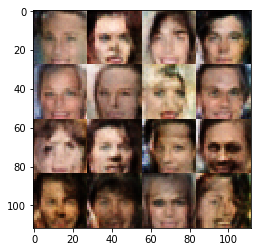

Epoch 0/1... Discriminator Loss: 1.1753... Generator Loss: 0.7962
Epoch 0/1... Discriminator Loss: 1.2654... Generator Loss: 0.7427
Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 1.2042
Epoch 0/1... Discriminator Loss: 1.0753... Generator Loss: 1.0390
Epoch 0/1... Discriminator Loss: 1.5167... Generator Loss: 0.5827


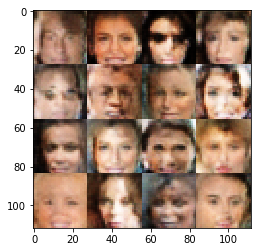

Epoch 0/1... Discriminator Loss: 1.3348... Generator Loss: 0.5367
Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 0.7644
Epoch 0/1... Discriminator Loss: 1.2200... Generator Loss: 1.0841
Epoch 0/1... Discriminator Loss: 1.2895... Generator Loss: 0.6400
Epoch 0/1... Discriminator Loss: 1.3102... Generator Loss: 0.6273


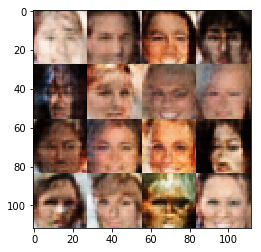

Epoch 0/1... Discriminator Loss: 1.3021... Generator Loss: 0.7067
Epoch 0/1... Discriminator Loss: 1.2848... Generator Loss: 0.8706
Epoch 0/1... Discriminator Loss: 1.3137... Generator Loss: 0.9614
Epoch 0/1... Discriminator Loss: 1.1593... Generator Loss: 0.9096
Epoch 0/1... Discriminator Loss: 0.9364... Generator Loss: 1.1840


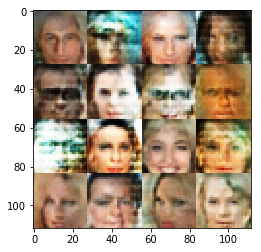

Epoch 0/1... Discriminator Loss: 1.3307... Generator Loss: 0.7205
Epoch 0/1... Discriminator Loss: 1.3985... Generator Loss: 0.6619
Epoch 0/1... Discriminator Loss: 1.6022... Generator Loss: 0.4372
Epoch 0/1... Discriminator Loss: 1.3829... Generator Loss: 0.6201
Epoch 0/1... Discriminator Loss: 1.2354... Generator Loss: 0.6572


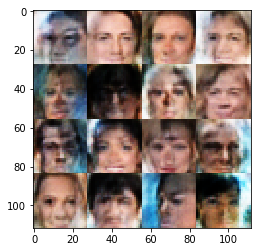

Epoch 0/1... Discriminator Loss: 1.3459... Generator Loss: 0.5610
Epoch 0/1... Discriminator Loss: 1.2543... Generator Loss: 1.0406
Epoch 0/1... Discriminator Loss: 1.2211... Generator Loss: 1.0994
Epoch 0/1... Discriminator Loss: 1.1993... Generator Loss: 1.2789
Epoch 0/1... Discriminator Loss: 1.1621... Generator Loss: 1.0044


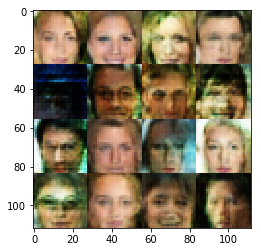

Epoch 0/1... Discriminator Loss: 1.5257... Generator Loss: 0.6310
Epoch 0/1... Discriminator Loss: 1.2274... Generator Loss: 1.1830
Epoch 0/1... Discriminator Loss: 1.3750... Generator Loss: 0.9524
Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 0.9373
Epoch 0/1... Discriminator Loss: 1.2784... Generator Loss: 0.7137


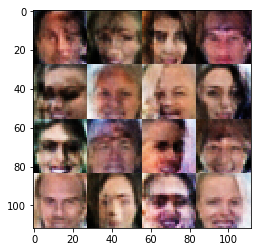

Epoch 0/1... Discriminator Loss: 1.2884... Generator Loss: 0.7587
Epoch 0/1... Discriminator Loss: 1.5185... Generator Loss: 0.5324
Epoch 0/1... Discriminator Loss: 1.1850... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.3775... Generator Loss: 0.6638
Epoch 0/1... Discriminator Loss: 1.2983... Generator Loss: 0.7234


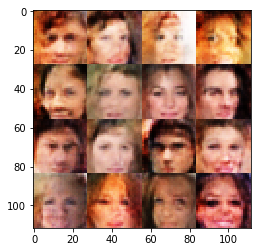

Epoch 0/1... Discriminator Loss: 1.0623... Generator Loss: 1.0353
Epoch 0/1... Discriminator Loss: 1.1283... Generator Loss: 0.9572
Epoch 0/1... Discriminator Loss: 1.2347... Generator Loss: 0.9236
Epoch 0/1... Discriminator Loss: 1.1685... Generator Loss: 0.8439
Epoch 0/1... Discriminator Loss: 1.1565... Generator Loss: 0.9354


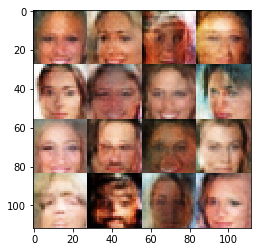

Epoch 0/1... Discriminator Loss: 1.3042... Generator Loss: 0.7055
Epoch 0/1... Discriminator Loss: 1.3424... Generator Loss: 0.5782
Epoch 0/1... Discriminator Loss: 1.1202... Generator Loss: 0.9730
Epoch 0/1... Discriminator Loss: 1.3278... Generator Loss: 0.6470
Epoch 0/1... Discriminator Loss: 1.3522... Generator Loss: 0.6207


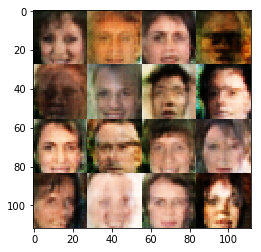

Epoch 0/1... Discriminator Loss: 1.2089... Generator Loss: 0.7514
Epoch 0/1... Discriminator Loss: 1.2066... Generator Loss: 0.7801
Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 0.9375
Epoch 0/1... Discriminator Loss: 1.1370... Generator Loss: 1.1040
Epoch 0/1... Discriminator Loss: 1.6397... Generator Loss: 0.4550


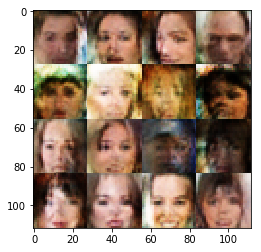

Epoch 0/1... Discriminator Loss: 1.4857... Generator Loss: 0.5111
Epoch 0/1... Discriminator Loss: 1.2849... Generator Loss: 0.7760
Epoch 0/1... Discriminator Loss: 1.3504... Generator Loss: 0.6441
Epoch 0/1... Discriminator Loss: 1.2476... Generator Loss: 0.6669
Epoch 0/1... Discriminator Loss: 1.2004... Generator Loss: 0.8098


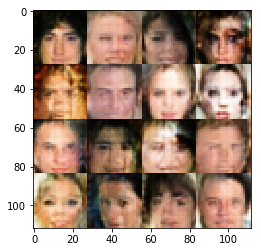

Epoch 0/1... Discriminator Loss: 1.4068... Generator Loss: 0.5653
Epoch 0/1... Discriminator Loss: 1.2193... Generator Loss: 0.7831
Epoch 0/1... Discriminator Loss: 1.2381... Generator Loss: 0.8245
Epoch 0/1... Discriminator Loss: 1.3489... Generator Loss: 0.6099
Epoch 0/1... Discriminator Loss: 1.4328... Generator Loss: 0.5640


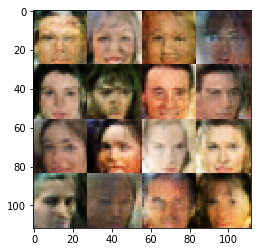

Epoch 0/1... Discriminator Loss: 1.1181... Generator Loss: 0.9008
Epoch 0/1... Discriminator Loss: 1.2871... Generator Loss: 1.1010
Epoch 0/1... Discriminator Loss: 1.2138... Generator Loss: 0.9467
Epoch 0/1... Discriminator Loss: 0.9522... Generator Loss: 1.2280
Epoch 0/1... Discriminator Loss: 1.2813... Generator Loss: 0.7017


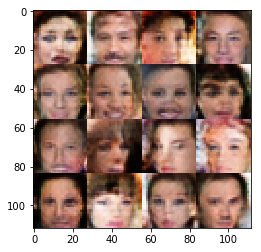

Epoch 0/1... Discriminator Loss: 1.2757... Generator Loss: 0.7536
Epoch 0/1... Discriminator Loss: 1.2693... Generator Loss: 0.6454
Epoch 0/1... Discriminator Loss: 1.0065... Generator Loss: 1.0461
Epoch 0/1... Discriminator Loss: 1.2086... Generator Loss: 0.8769
Epoch 0/1... Discriminator Loss: 1.3262... Generator Loss: 0.6540


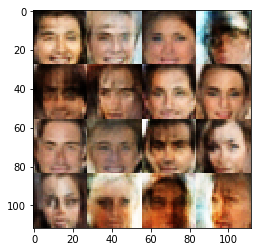

Epoch 0/1... Discriminator Loss: 1.2260... Generator Loss: 0.9415
Epoch 0/1... Discriminator Loss: 1.2390... Generator Loss: 0.6872
Epoch 0/1... Discriminator Loss: 1.3022... Generator Loss: 0.8359
Epoch 0/1... Discriminator Loss: 1.3780... Generator Loss: 0.6513
Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.9967


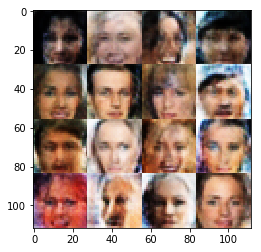

Epoch 0/1... Discriminator Loss: 1.1013... Generator Loss: 0.9633
Epoch 0/1... Discriminator Loss: 1.2129... Generator Loss: 0.6947
Epoch 0/1... Discriminator Loss: 0.9532... Generator Loss: 1.3083
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.7859
Epoch 0/1... Discriminator Loss: 1.2364... Generator Loss: 0.7873


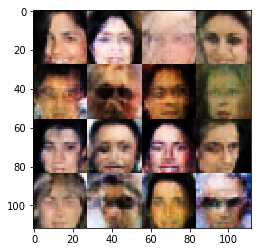

Epoch 0/1... Discriminator Loss: 1.3238... Generator Loss: 0.7695
Epoch 0/1... Discriminator Loss: 1.1800... Generator Loss: 0.7677
Epoch 0/1... Discriminator Loss: 1.3676... Generator Loss: 0.6181
Epoch 0/1... Discriminator Loss: 1.2875... Generator Loss: 0.8233
Epoch 0/1... Discriminator Loss: 1.2110... Generator Loss: 0.8335


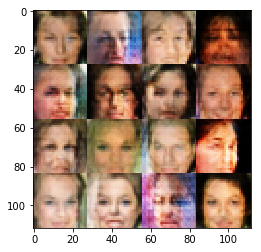

Epoch 0/1... Discriminator Loss: 1.2304... Generator Loss: 1.0655
Epoch 0/1... Discriminator Loss: 1.2734... Generator Loss: 0.7086
Epoch 0/1... Discriminator Loss: 1.1835... Generator Loss: 0.7148
Epoch 0/1... Discriminator Loss: 1.3423... Generator Loss: 1.2361
Epoch 0/1... Discriminator Loss: 1.2362... Generator Loss: 1.2388


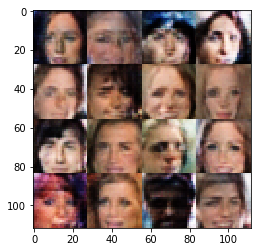

Epoch 0/1... Discriminator Loss: 1.3432... Generator Loss: 0.6025
Epoch 0/1... Discriminator Loss: 1.1996... Generator Loss: 0.8214
Epoch 0/1... Discriminator Loss: 1.5981... Generator Loss: 0.4876
Epoch 0/1... Discriminator Loss: 1.0945... Generator Loss: 0.8936
Epoch 0/1... Discriminator Loss: 1.1136... Generator Loss: 0.9879


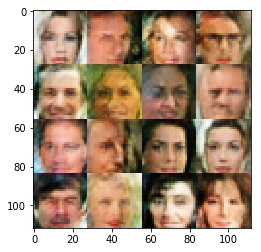

Epoch 0/1... Discriminator Loss: 1.4263... Generator Loss: 0.5255
Epoch 0/1... Discriminator Loss: 1.2647... Generator Loss: 0.7184
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.6255
Epoch 0/1... Discriminator Loss: 1.0299... Generator Loss: 0.9490
Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.6133


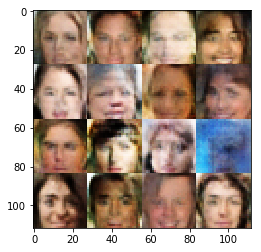

Epoch 0/1... Discriminator Loss: 1.3549... Generator Loss: 0.6492
Epoch 0/1... Discriminator Loss: 1.2400... Generator Loss: 0.8776
Epoch 0/1... Discriminator Loss: 1.0776... Generator Loss: 0.8975
Epoch 0/1... Discriminator Loss: 1.3998... Generator Loss: 0.5557
Epoch 0/1... Discriminator Loss: 1.2674... Generator Loss: 0.6904


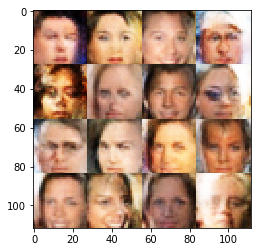

Epoch 0/1... Discriminator Loss: 1.1893... Generator Loss: 0.7069
Epoch 0/1... Discriminator Loss: 1.1978... Generator Loss: 0.9340
Epoch 0/1... Discriminator Loss: 1.2868... Generator Loss: 0.8574
Epoch 0/1... Discriminator Loss: 1.1406... Generator Loss: 0.7728
Epoch 0/1... Discriminator Loss: 1.4045... Generator Loss: 0.5184


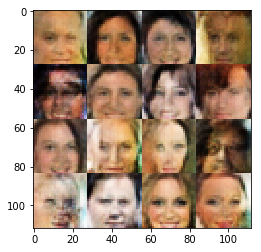

Epoch 0/1... Discriminator Loss: 1.2946... Generator Loss: 0.7325
Epoch 0/1... Discriminator Loss: 1.2324... Generator Loss: 0.8215
Epoch 0/1... Discriminator Loss: 1.2867... Generator Loss: 0.7654
Epoch 0/1... Discriminator Loss: 1.5742... Generator Loss: 0.4348
Epoch 0/1... Discriminator Loss: 1.4876... Generator Loss: 0.5501


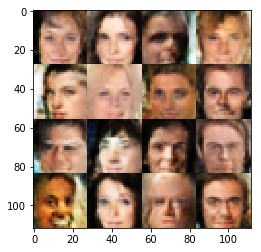

Epoch 0/1... Discriminator Loss: 1.1149... Generator Loss: 1.3426
Epoch 0/1... Discriminator Loss: 1.2844... Generator Loss: 0.8905
Epoch 0/1... Discriminator Loss: 1.5408... Generator Loss: 0.4929
Epoch 0/1... Discriminator Loss: 1.2710... Generator Loss: 0.7023
Epoch 0/1... Discriminator Loss: 1.3568... Generator Loss: 0.5790


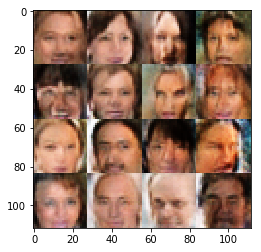

Epoch 0/1... Discriminator Loss: 1.3893... Generator Loss: 0.5507
Epoch 0/1... Discriminator Loss: 1.1898... Generator Loss: 1.0378
Epoch 0/1... Discriminator Loss: 1.2834... Generator Loss: 0.7817
Epoch 0/1... Discriminator Loss: 1.0381... Generator Loss: 0.9137
Epoch 0/1... Discriminator Loss: 1.3918... Generator Loss: 0.5624


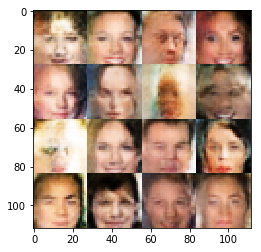

Epoch 0/1... Discriminator Loss: 1.1003... Generator Loss: 1.0059
Epoch 0/1... Discriminator Loss: 1.0597... Generator Loss: 0.9479
Epoch 0/1... Discriminator Loss: 1.1894... Generator Loss: 0.7893
Epoch 0/1... Discriminator Loss: 0.9940... Generator Loss: 1.5796
Epoch 0/1... Discriminator Loss: 1.4571... Generator Loss: 0.8109


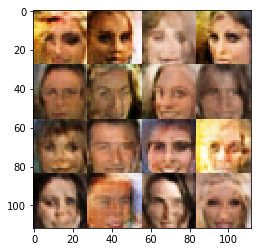

Epoch 0/1... Discriminator Loss: 1.2477... Generator Loss: 0.9715
Epoch 0/1... Discriminator Loss: 1.3726... Generator Loss: 0.7297
Epoch 0/1... Discriminator Loss: 1.1914... Generator Loss: 0.7652
Epoch 0/1... Discriminator Loss: 1.1666... Generator Loss: 1.0373
Epoch 0/1... Discriminator Loss: 1.4161... Generator Loss: 0.5670


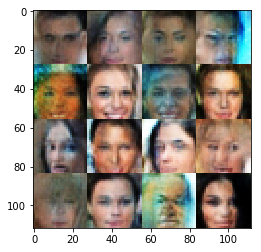

Epoch 0/1... Discriminator Loss: 1.3609... Generator Loss: 0.5592
Epoch 0/1... Discriminator Loss: 1.1476... Generator Loss: 0.8061
Epoch 0/1... Discriminator Loss: 1.4190... Generator Loss: 0.5915
Epoch 0/1... Discriminator Loss: 1.3676... Generator Loss: 0.6391
Epoch 0/1... Discriminator Loss: 1.2358... Generator Loss: 0.7243


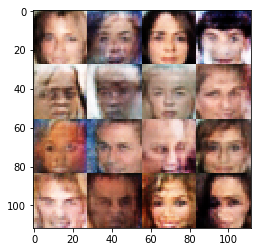

Epoch 0/1... Discriminator Loss: 1.6769... Generator Loss: 0.4689
Epoch 0/1... Discriminator Loss: 1.5356... Generator Loss: 0.5533
Epoch 0/1... Discriminator Loss: 1.2641... Generator Loss: 0.7232
Epoch 0/1... Discriminator Loss: 1.1400... Generator Loss: 1.0527
Epoch 0/1... Discriminator Loss: 1.2965... Generator Loss: 0.6219


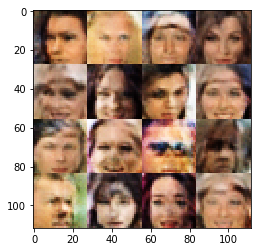

Epoch 0/1... Discriminator Loss: 1.2130... Generator Loss: 1.0387
Epoch 0/1... Discriminator Loss: 1.0560... Generator Loss: 1.1653
Epoch 0/1... Discriminator Loss: 1.4396... Generator Loss: 0.6177
Epoch 0/1... Discriminator Loss: 1.3337... Generator Loss: 0.6702
Epoch 0/1... Discriminator Loss: 1.1214... Generator Loss: 0.8903


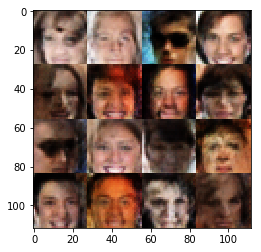

Epoch 0/1... Discriminator Loss: 1.4902... Generator Loss: 0.5526
Epoch 0/1... Discriminator Loss: 1.2397... Generator Loss: 0.8089
Epoch 0/1... Discriminator Loss: 1.5751... Generator Loss: 0.5621
Epoch 0/1... Discriminator Loss: 1.1005... Generator Loss: 0.9010
Epoch 0/1... Discriminator Loss: 1.4118... Generator Loss: 0.6846


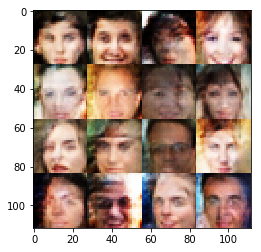

Epoch 0/1... Discriminator Loss: 1.0741... Generator Loss: 1.0034
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.6499
Epoch 0/1... Discriminator Loss: 1.3772... Generator Loss: 0.6356
Epoch 0/1... Discriminator Loss: 1.0871... Generator Loss: 1.0873
Epoch 0/1... Discriminator Loss: 1.1241... Generator Loss: 0.8960


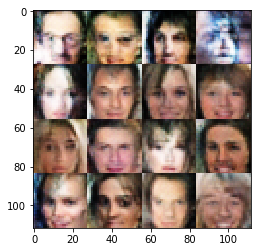

Epoch 0/1... Discriminator Loss: 1.8796... Generator Loss: 0.3792
Epoch 0/1... Discriminator Loss: 1.1154... Generator Loss: 0.7939
Epoch 0/1... Discriminator Loss: 1.2266... Generator Loss: 1.0035
Epoch 0/1... Discriminator Loss: 1.2179... Generator Loss: 0.7684
Epoch 0/1... Discriminator Loss: 1.2906... Generator Loss: 0.6563


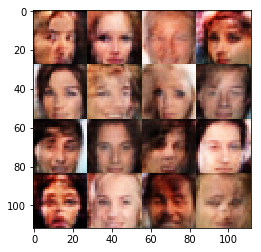

Epoch 0/1... Discriminator Loss: 1.1145... Generator Loss: 0.9152
Epoch 0/1... Discriminator Loss: 1.2165... Generator Loss: 0.8268
Epoch 0/1... Discriminator Loss: 1.3710... Generator Loss: 0.7336
Epoch 0/1... Discriminator Loss: 1.2926... Generator Loss: 0.7616
Epoch 0/1... Discriminator Loss: 1.2298... Generator Loss: 0.8904


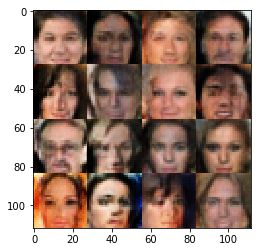

Epoch 0/1... Discriminator Loss: 1.1745... Generator Loss: 0.8275
Epoch 0/1... Discriminator Loss: 1.3546... Generator Loss: 0.6994
Epoch 0/1... Discriminator Loss: 1.3633... Generator Loss: 0.6413
Epoch 0/1... Discriminator Loss: 1.0162... Generator Loss: 1.3128
Epoch 0/1... Discriminator Loss: 1.3386... Generator Loss: 0.6523


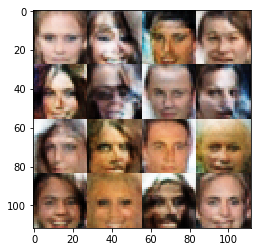

Epoch 0/1... Discriminator Loss: 1.4011... Generator Loss: 0.7044
Epoch 0/1... Discriminator Loss: 1.2047... Generator Loss: 0.9871
Epoch 0/1... Discriminator Loss: 1.1038... Generator Loss: 0.9456
Epoch 0/1... Discriminator Loss: 1.2301... Generator Loss: 0.8516
Epoch 0/1... Discriminator Loss: 1.3486... Generator Loss: 0.6107


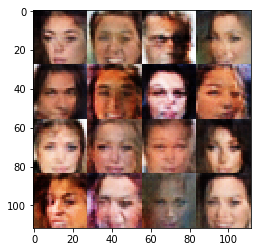

Epoch 0/1... Discriminator Loss: 1.4447... Generator Loss: 0.5706
Epoch 0/1... Discriminator Loss: 1.0136... Generator Loss: 1.0546
Epoch 0/1... Discriminator Loss: 1.6110... Generator Loss: 0.4309
Epoch 0/1... Discriminator Loss: 1.2449... Generator Loss: 0.8596
Epoch 0/1... Discriminator Loss: 1.3055... Generator Loss: 1.0511


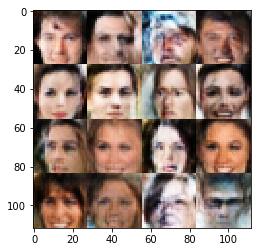

Epoch 0/1... Discriminator Loss: 1.3724... Generator Loss: 0.6358
Epoch 0/1... Discriminator Loss: 1.1688... Generator Loss: 0.8877
Epoch 0/1... Discriminator Loss: 1.2770... Generator Loss: 0.6293
Epoch 0/1... Discriminator Loss: 1.1312... Generator Loss: 0.8516
Epoch 0/1... Discriminator Loss: 1.2903... Generator Loss: 0.7192


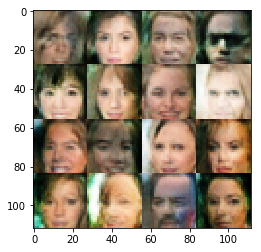

Epoch 0/1... Discriminator Loss: 1.2137... Generator Loss: 0.7935
Epoch 0/1... Discriminator Loss: 1.2100... Generator Loss: 0.9636
Epoch 0/1... Discriminator Loss: 1.5802... Generator Loss: 0.4392
Epoch 0/1... Discriminator Loss: 0.9787... Generator Loss: 0.9919
Epoch 0/1... Discriminator Loss: 1.2775... Generator Loss: 0.7062


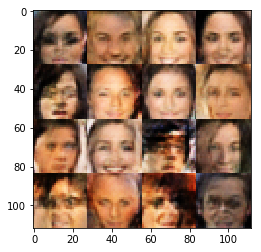

Epoch 0/1... Discriminator Loss: 1.3599... Generator Loss: 0.6017
Epoch 0/1... Discriminator Loss: 1.2389... Generator Loss: 0.6798
Epoch 0/1... Discriminator Loss: 1.4791... Generator Loss: 1.0746
Epoch 0/1... Discriminator Loss: 1.3286... Generator Loss: 0.6791
Epoch 0/1... Discriminator Loss: 1.4765... Generator Loss: 0.5691


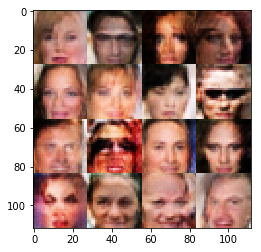

Epoch 0/1... Discriminator Loss: 1.4117... Generator Loss: 0.7008
Epoch 0/1... Discriminator Loss: 1.2792... Generator Loss: 0.6531
Epoch 0/1... Discriminator Loss: 1.2943... Generator Loss: 0.6883
Epoch 0/1... Discriminator Loss: 1.1576... Generator Loss: 1.0250
Epoch 0/1... Discriminator Loss: 1.4535... Generator Loss: 0.6009


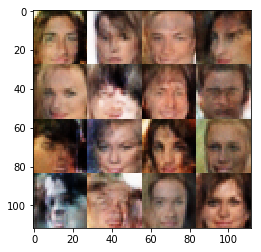

Epoch 0/1... Discriminator Loss: 1.4022... Generator Loss: 0.6528
Epoch 0/1... Discriminator Loss: 1.3325... Generator Loss: 0.8608
Epoch 0/1... Discriminator Loss: 1.2078... Generator Loss: 0.6553
Epoch 0/1... Discriminator Loss: 1.3082... Generator Loss: 0.7579
Epoch 0/1... Discriminator Loss: 1.3558... Generator Loss: 0.8720


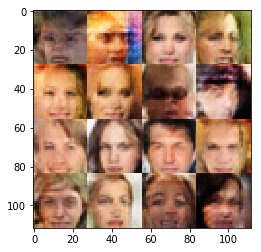

Epoch 0/1... Discriminator Loss: 1.3202... Generator Loss: 0.8335
Epoch 0/1... Discriminator Loss: 1.2326... Generator Loss: 0.9389
Epoch 0/1... Discriminator Loss: 1.0523... Generator Loss: 1.0955
Epoch 0/1... Discriminator Loss: 1.1228... Generator Loss: 0.9838
Epoch 0/1... Discriminator Loss: 1.5372... Generator Loss: 0.4919


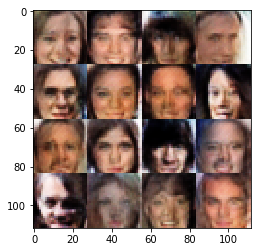

Epoch 0/1... Discriminator Loss: 1.2377... Generator Loss: 0.8113
Epoch 0/1... Discriminator Loss: 1.3623... Generator Loss: 0.8420
Epoch 0/1... Discriminator Loss: 1.2237... Generator Loss: 0.7512
Epoch 0/1... Discriminator Loss: 1.2371... Generator Loss: 0.8919
Epoch 0/1... Discriminator Loss: 1.3478... Generator Loss: 0.6420


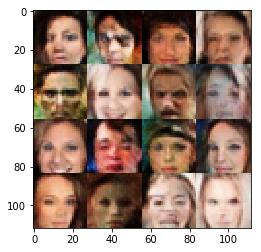

Epoch 0/1... Discriminator Loss: 1.2303... Generator Loss: 0.6728
Epoch 0/1... Discriminator Loss: 1.4646... Generator Loss: 0.5228
Epoch 0/1... Discriminator Loss: 1.0563... Generator Loss: 1.0384
Epoch 0/1... Discriminator Loss: 1.3589... Generator Loss: 0.5978
Epoch 0/1... Discriminator Loss: 1.3469... Generator Loss: 0.7011


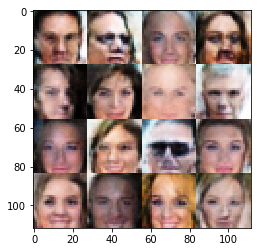

Epoch 0/1... Discriminator Loss: 1.1729... Generator Loss: 0.8734
Epoch 0/1... Discriminator Loss: 1.1629... Generator Loss: 0.9712
Epoch 0/1... Discriminator Loss: 1.3618... Generator Loss: 0.7179
Epoch 0/1... Discriminator Loss: 1.2914... Generator Loss: 0.6883
Epoch 0/1... Discriminator Loss: 1.2778... Generator Loss: 0.7001


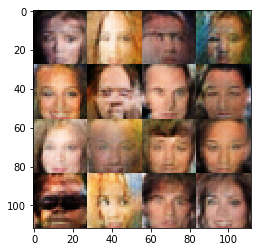

Epoch 0/1... Discriminator Loss: 1.3795... Generator Loss: 0.5925
Epoch 0/1... Discriminator Loss: 1.3576... Generator Loss: 0.6646
Epoch 0/1... Discriminator Loss: 1.2715... Generator Loss: 0.8281
Epoch 0/1... Discriminator Loss: 1.2822... Generator Loss: 0.9802
Epoch 0/1... Discriminator Loss: 1.3497... Generator Loss: 0.5440


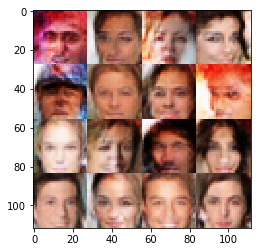

Epoch 0/1... Discriminator Loss: 1.3783... Generator Loss: 0.6805
Epoch 0/1... Discriminator Loss: 1.1910... Generator Loss: 0.8476
Epoch 0/1... Discriminator Loss: 1.1716... Generator Loss: 0.8749
Epoch 0/1... Discriminator Loss: 1.3542... Generator Loss: 0.6745
Epoch 0/1... Discriminator Loss: 1.1452... Generator Loss: 0.9046


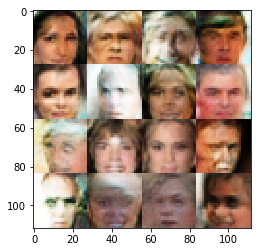

Epoch 0/1... Discriminator Loss: 1.1876... Generator Loss: 1.0836
Epoch 0/1... Discriminator Loss: 1.2296... Generator Loss: 0.7666
Epoch 0/1... Discriminator Loss: 1.2039... Generator Loss: 0.8852
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.6914
Epoch 0/1... Discriminator Loss: 1.1519... Generator Loss: 0.7251


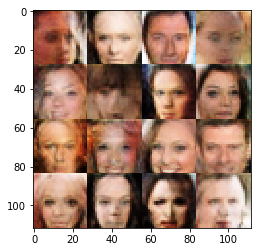

Epoch 0/1... Discriminator Loss: 1.2085... Generator Loss: 0.7172
Epoch 0/1... Discriminator Loss: 1.1285... Generator Loss: 0.8769
Epoch 0/1... Discriminator Loss: 1.3823... Generator Loss: 0.6411
Epoch 0/1... Discriminator Loss: 1.2197... Generator Loss: 0.8830
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 0.8480


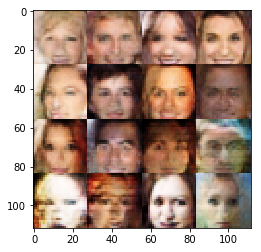

Epoch 0/1... Discriminator Loss: 1.4243... Generator Loss: 0.6476
Epoch 0/1... Discriminator Loss: 1.3834... Generator Loss: 0.6693
Epoch 0/1... Discriminator Loss: 1.1839... Generator Loss: 0.8201
Epoch 0/1... Discriminator Loss: 1.2318... Generator Loss: 0.7590
Epoch 0/1... Discriminator Loss: 1.4173... Generator Loss: 0.4942


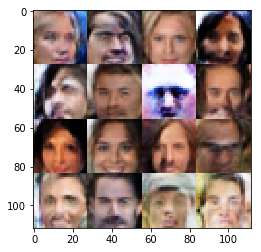

Epoch 0/1... Discriminator Loss: 1.2227... Generator Loss: 0.8436
Epoch 0/1... Discriminator Loss: 1.2935... Generator Loss: 0.7983
Epoch 0/1... Discriminator Loss: 1.1203... Generator Loss: 1.0099
Epoch 0/1... Discriminator Loss: 1.3454... Generator Loss: 0.5657
Epoch 0/1... Discriminator Loss: 1.3969... Generator Loss: 0.5502


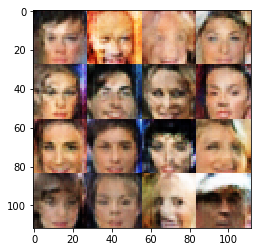

Epoch 0/1... Discriminator Loss: 1.4103... Generator Loss: 0.5197
Epoch 0/1... Discriminator Loss: 1.1553... Generator Loss: 0.8887
Epoch 0/1... Discriminator Loss: 1.2352... Generator Loss: 0.7454
Epoch 0/1... Discriminator Loss: 1.2413... Generator Loss: 0.7196
Epoch 0/1... Discriminator Loss: 1.3113... Generator Loss: 0.7595


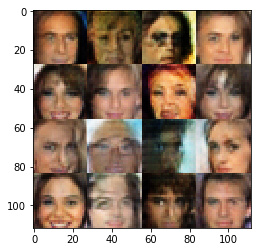

Epoch 0/1... Discriminator Loss: 1.2853... Generator Loss: 0.7553
Epoch 0/1... Discriminator Loss: 1.3222... Generator Loss: 0.9133
Epoch 0/1... Discriminator Loss: 1.4993... Generator Loss: 0.6130
Epoch 0/1... Discriminator Loss: 1.4251... Generator Loss: 0.6283
Epoch 0/1... Discriminator Loss: 1.3957... Generator Loss: 0.5897


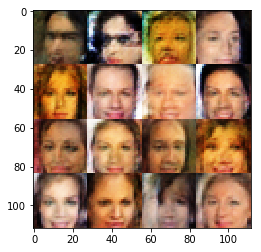

Epoch 0/1... Discriminator Loss: 1.3998... Generator Loss: 0.5229
Epoch 0/1... Discriminator Loss: 1.5106... Generator Loss: 0.5239
Epoch 0/1... Discriminator Loss: 1.2323... Generator Loss: 0.8621
Epoch 0/1... Discriminator Loss: 1.3194... Generator Loss: 0.7170
Epoch 0/1... Discriminator Loss: 1.2008... Generator Loss: 0.8208


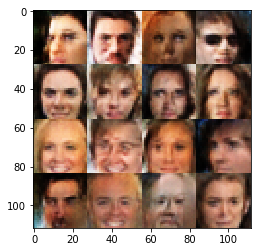

Epoch 0/1... Discriminator Loss: 1.3711... Generator Loss: 0.6635
Epoch 0/1... Discriminator Loss: 1.0169... Generator Loss: 0.9920
Epoch 0/1... Discriminator Loss: 1.2192... Generator Loss: 0.8740
Epoch 0/1... Discriminator Loss: 1.4318... Generator Loss: 0.5504
Epoch 0/1... Discriminator Loss: 1.3010... Generator Loss: 0.6843


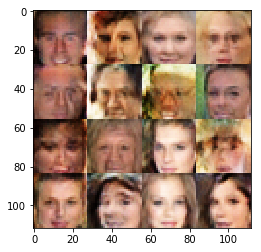

Epoch 0/1... Discriminator Loss: 1.6517... Generator Loss: 0.4225
Epoch 0/1... Discriminator Loss: 1.3656... Generator Loss: 0.5893
Epoch 0/1... Discriminator Loss: 1.3810... Generator Loss: 0.7088
Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 1.0805
Epoch 0/1... Discriminator Loss: 1.2324... Generator Loss: 0.7218


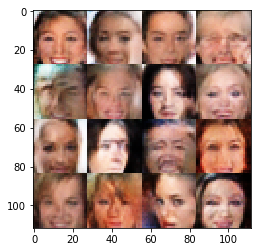

Epoch 0/1... Discriminator Loss: 1.2896... Generator Loss: 0.6756
Epoch 0/1... Discriminator Loss: 1.3819... Generator Loss: 0.7284
Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.7706
Epoch 0/1... Discriminator Loss: 1.1916... Generator Loss: 1.0239


In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。